# LSTM and SIR Models

### Goals

Attempt to run and optimize an LSTM model, starting with a single location (Hubei Province) to all of China and eventually all locations with confirmed coronavirus cases.

Also attempt to leverage SIR models if LSTM appears unworkable.

### Challenges
1. LSTM needs TONS of training data. Each of ~104 locations has ~80 time steps (days). This sparse matrix is challenging to train on.
  1. Data may need to be imputed using an epidemiological curve. 
    1. See SIR model which can be developed for each location provided population and Ro constants. This model can be adapted to intake an origin-destination flow matrix as well.
    2. Perhaps every location's first "time step" should be considered as "Day 1" regardless of actual date?
2. Spatial temporal aspect is tricky - training one model on multiple location-dependent characteristics to predict values in the time series. 


In [189]:
import pandas as pd
import numpy as np
from numpy import array, hstack
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Flatten, TimeDistributed, ConvLSTM2D
from keras.layers.convolutional import Conv1D, MaxPooling1D

warnings.filterwarnings(action = 'ignore')
sns.set_style('whitegrid')
sns.set_context('talk')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Data Prep

104 of 105 reported locations to which coronavirus has spread are within 500 km of an airport.

In [2]:
df = pd.read_csv('time_series_cases.csv', index_col=0)
df['date'] = pd.to_datetime(df['date']) # datetime format not read in
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8424 entries, 0 to 8423
Data columns (total 15 columns):
Province/State        8424 non-null object
city_county_state     8424 non-null object
country               8424 non-null object
hospital beds         8424 non-null float64
physicians            8424 non-null float64
GDP_per_capita        8424 non-null float64
SPAR_index            8424 non-null float64
IVDI_score            8424 non-null float64
city_pop              8424 non-null float64
effective_dist        8424 non-null float64
geo_dist              8424 non-null float64
ann_pass_flux         8424 non-null float64
connected_airports    8424 non-null float64
date                  8424 non-null datetime64[ns]
confirmed_cases       8424 non-null float64
dtypes: datetime64[ns](1), float64(11), object(3)
memory usage: 1.0+ MB


Next:

1. Sort the entire dataset by three location variables (a unique combination) to observe confirmed time series.

2. Create location ids in lieu of the unique 3-column combination. This allows us to iterate through the dataset more easily as needed.

In [336]:
df = df.sort_values(by = ['Province/State', 
                          'city_county_state', 
                          'country', 
                          'date']).reset_index(drop = True)

df['loc_id'] = list(zip(df['Province/State'], df['city_county_state'], df['country']))
df['loc_id'] = pd.factorize(df['loc_id'])[0]

df.head()

print("Number of Unique Locations: ", len(df.loc_id.unique()))
print("Number of Countries: ", len(df.country.unique()))

Number of Unique Locations:  104
Number of Countries:  52


In [31]:
df.describe().T # only numeric variables. min/max scale prior to training.

,count,mean,std,min,25%,50%,75%,max
hospital beds,8424.0,3.775350e+00,2.019486e+00,0.300000,2.900000e+00,3.800000e+00,4.200000e+00,1.340000e+01
physicians,8424.0,2.413649e+00,1.124927e+00,0.168200,1.785500e+00,2.288650e+00,2.676050e+00,6.146800e+00
GDP_per_capita,8424.0,3.606712e+04,2.321249e+04,1955.006208,1.823661e+04,2.789307e+04,5.550881e+04,1.238922e+05
SPAR_index,8424.0,8.426563e+01,1.599306e+01,23.076923,8.121154e+01,9.100000e+01,9.430769e+01,1.000000e+02
IVDI_score,8424.0,7.085047e-01,1.237450e-01,0.257002,6.762941e-01,6.762941e-01,8.197449e-01,8.893884e-01
city_pop,8424.0,1.615437e+03,1.222787e+03,393.604000,1.131799e+03,1.399381e+03,1.610483e+03,7.594105e+03
effective_dist,8424.0,1.052234e+01,3.421587e+00,5.199450,6.094246e+00,1.188978e+01,1.341361e+01,1.600038e+01
geo_dist,8424.0,5.451523e+03,4.123802e+03,341.482235,1.311241e+03,5.744366e+03,8.595279e+03,1.778360e+04
ann_pass_flux,8424.0,4.445951e+06,2.488460e+06,299523.000000,2.803675e+06,4.183885e+06,5.844822e+06,1.149651e+07
connected_airports,8424.0,3.562572e+01,1.703531e+01,7.000000,2.214583e+01,3.298958e+01,4.495417e+01,8.437500e+01


### Missing data
There are some zero case values representing null information between observed cases for a given location. The goal below is to impute value of previous non-zero case count until a new observation of non-zero value.

In [7]:
df.confirmed_cases.value_counts()

0.0        5824
1.0         586
2.0         264
4.0         104
3.0          94
           ... 
381.0         1
626.0         1
59989.0       1
1011.0        1
1159.0        1
Name: confirmed_cases, Length: 527, dtype: int64

In [5]:
'''code below does not work, need to find a better way'''

# import progressbar

# bar = progressbar.ProgressBar(maxval=len(df.loc_id.unique())).start()

# for location in df.loc_id.unique():
#     for index, case_count in enumerate(df.loc[df['loc_id'] == location].confirmed_cases):
#         while index != 0:
#             if (df.loc[df['loc_id'] == location].confirmed_cases[index] == 0) & (df.loc[df['loc_id'] == location].confirmed_cases[index-1] != 0):
#                 df.loc[df['loc_id'] == location].confirmed_cases[index] = df.confirmed_cases[index-1]
#     bar.update(location)

'code below does not work, need to find a better way'

### Time lag functions

Allowing the model to intake a given number of values and predict the next value.
For example, case counts = [100 200 300] --> prediction for next count = 400.

The first two functions are for univariate models and the last for multivariate.

In [99]:
# function from class for univariate time series.

def create_data(timeseries, lag=1, as_array=True):
    if not isinstance(timeseries, pd.Series):
        timeseries = pd.Series(timeseries.ravel())
    y = timeseries[lag:]
    X = pd.DataFrame({'lag'+str(lag-i):timeseries.shift(-i) for i in range(0, lag)}).dropna().iloc[0:-1, :]
    if not as_array:
        return X, y
    else:
        return X.values, y.values

In [100]:
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [307]:
#  https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:, -1:]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [396]:
# split a univariate sequence into samples and return predictions for multistep output
def split_sequence_multistep(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [397]:
# split a multivariate sequence into samples for multistep output
def split_sequences_multistep(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Timestamps and LSTM

Replace the timestamp with the number of days since Dec 8th to correct an LSTM fit error. The function below is not necessary for LSTM models using time lag implementation (even lag =1).

In [45]:
def date_to_string(df):
    dic = {}
    for index, date in enumerate(df.date.unique()):
        x = {date : index}
        dic.update(x)

    df.date = df.date.map(dic)
    return df

### Cases by location

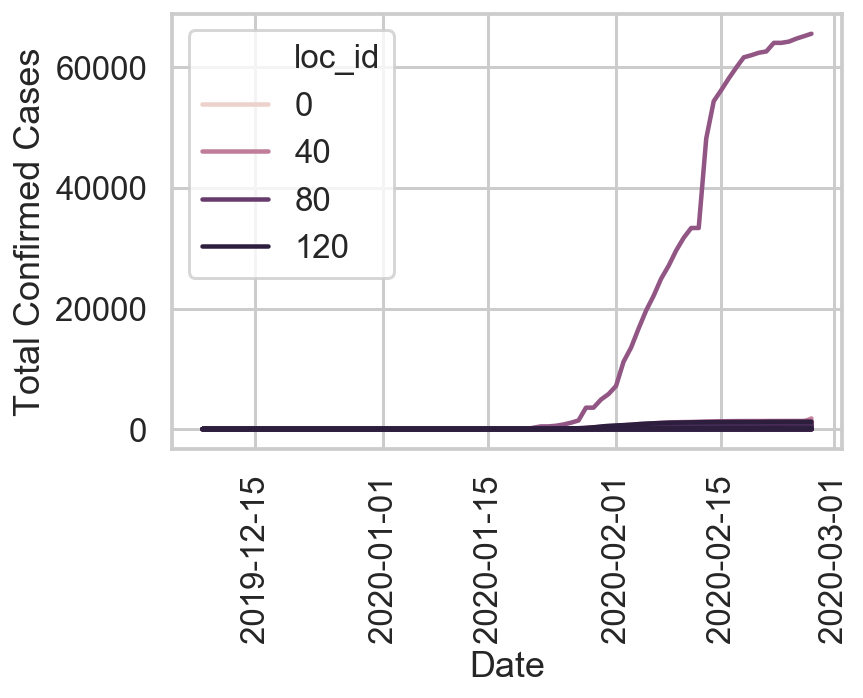

In [47]:
sns.lineplot(y = 'confirmed_cases', x = 'date', hue = 'loc_id', data = df, ci = None)
plt.ylabel('Total Confirmed Cases')
plt.xlabel('Date')
plt.xticks(rotation='vertical')
plt.legend(loc = 'best')
plt.show()

### Cases by country

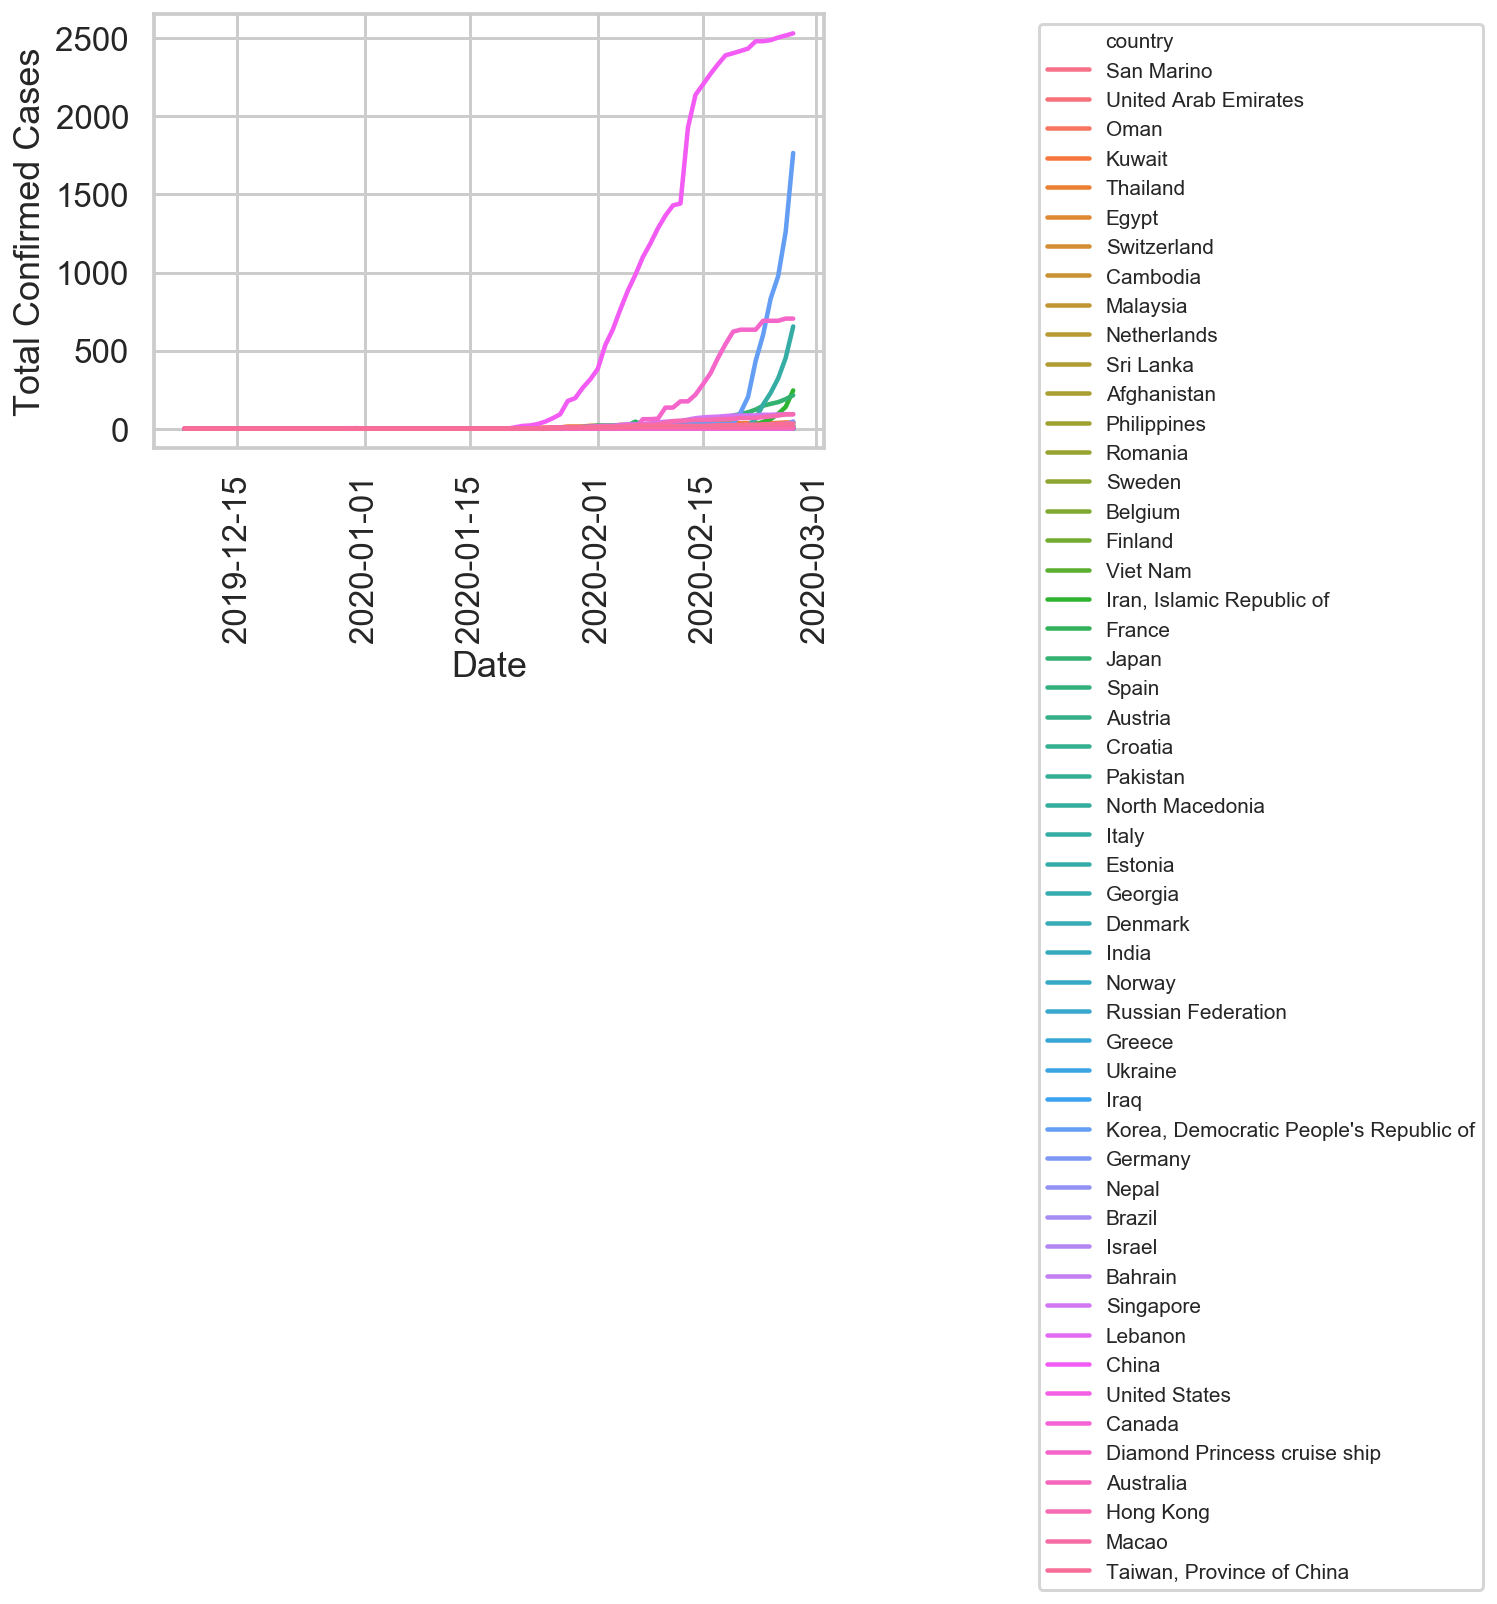

In [48]:
sns.lineplot(y = 'confirmed_cases', x = 'date', hue = 'country', data = df, ci = None,
            palette = sns.color_palette('husl', len(df.country.unique())))
plt.ylabel('Total Confirmed Cases')
plt.xlabel('Date')
plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor = (1, 0., 1, 1), fontsize = 'xx-small')
plt.show()

## Hubei Province

Hubei Province, China, for which most time series data is available.

In [314]:
hubei_df = df.loc[df['Province/State'] == 'Hubei'].reset_index(drop=True)
hubei_df.head()

,Province/State,city_county_state,country,hospital beds,physicians,GDP_per_capita,SPAR_index,IVDI_score,city_pop,effective_dist,geo_dist,ann_pass_flux,connected_airports,date,confirmed_cases,loc_id
0,Hubei,", Duodao District, Hubei",China,4.2,1.7855,18236.612982,94.307692,0.676294,1154.866872,6.111029,341.482235,2.842581e+06,29.033333,2019-12-08,1.0,62
1,Hubei,", Duodao District, Hubei",China,4.2,1.7855,18236.612982,94.307692,0.676294,1154.866872,6.111029,341.482235,2.842581e+06,29.033333,2019-12-09,0.0,62
2,Hubei,", Duodao District, Hubei",China,4.2,1.7855,18236.612982,94.307692,0.676294,1154.866872,6.111029,341.482235,2.842581e+06,29.033333,2019-12-10,0.0,62
3,Hubei,", Duodao District, Hubei",China,4.2,1.7855,18236.612982,94.307692,0.676294,1154.866872,6.111029,341.482235,2.842581e+06,29.033333,2019-12-11,2.0,62
4,Hubei,", Duodao District, Hubei",China,4.2,1.7855,18236.612982,94.307692,0.676294,1154.866872,6.111029,341.482235,2.842581e+06,29.033333,2019-12-12,5.0,62


### Univariate, vanilla, lag = 3

This is a baseline model.

Features for one location are static except for target variable (number of confirmed cases).

Source code: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [315]:
# define split_sequence function inputs
train_size = 0.8
seq = hubei_df.confirmed_cases
n_steps = 3

X, y = split_sequence(seq, n_steps)

In [316]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1 # univariate
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [317]:
trainX = X[:int(train_size*len(X))]
trainy = y[:int(train_size*len(y))]
testX = X[int(train_size*len(X)):]
testy = y[int(train_size*len(y)):]

In [174]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

Train on 62 samples, validate on 16 samples
Epoch 1/200
62/62 [==============================] - 2s 36ms/step - loss: 105472799.3548 - val_loss: 3936580096.0000
Epoch 2/200
62/62 [==============================] - 0s 249us/step - loss: 100887339.0968 - val_loss: 3595560960.0000
Epoch 3/200
62/62 [==============================] - 0s 231us/step - loss: 96549020.6452 - val_loss: 3555746304.0000
Epoch 4/200
62/62 [==============================] - 0s 431us/step - loss: 94563319.7419 - val_loss: 3434703360.0000
Epoch 5/200
62/62 [==============================] - 0s 328us/step - loss: 93120538.7097 - val_loss: 3390568448.0000
Epoch 6/200
62/62 [==============================] - 0s 293us/step - loss: 92025622.9677 - val_loss: 3346380288.0000
Epoch 7/200
62/62 [==============================] - 0s 323us/step - loss: 90899049.0323 - val_loss: 3302734592.0000
Epoch 8/200
62/62 [==============================] - 0s 263us/step - loss: 89918559.2258 - val_loss: 3122669568.0000
Epoch 9/200
62/62 [

62/62 [==============================] - 0s 406us/step - loss: 1331642.1310 - val_loss: 81041440.0000
Epoch 71/200
62/62 [==============================] - 0s 368us/step - loss: 1333547.0524 - val_loss: 42637472.0000
Epoch 72/200
62/62 [==============================] - 0s 353us/step - loss: 1336605.7500 - val_loss: 117451256.0000
Epoch 73/200
62/62 [==============================] - 0s 345us/step - loss: 1334510.7581 - val_loss: 127261536.0000
Epoch 74/200
62/62 [==============================] - 0s 425us/step - loss: 1334277.0202 - val_loss: 121461840.0000
Epoch 75/200
62/62 [==============================] - 0s 391us/step - loss: 1330476.9718 - val_loss: 119573912.0000
Epoch 76/200
62/62 [==============================] - 0s 354us/step - loss: 1341060.9476 - val_loss: 113039632.0000
Epoch 77/200
62/62 [==============================] - 0s 446us/step - loss: 1321465.2056 - val_loss: 108143600.0000
Epoch 78/200
62/62 [==============================] - 0s 297us/step - loss: 1315560.961

62/62 [==============================] - 0s 311us/step - loss: 1185136.4637 - val_loss: 22125188.0000
Epoch 141/200
62/62 [==============================] - 0s 329us/step - loss: 1175097.5403 - val_loss: 21005244.0000
Epoch 142/200
62/62 [==============================] - 0s 307us/step - loss: 1011564.0282 - val_loss: 21223388.0000
Epoch 143/200
62/62 [==============================] - 0s 331us/step - loss: 1029613.7661 - val_loss: 22950592.0000
Epoch 144/200
62/62 [==============================] - 0s 344us/step - loss: 973688.6512 - val_loss: 26509270.0000
Epoch 145/200
62/62 [==============================] - 0s 349us/step - loss: 897967.6573 - val_loss: 31693986.0000
Epoch 146/200
62/62 [==============================] - 0s 325us/step - loss: 1016903.8105 - val_loss: 61896736.0000
Epoch 147/200
62/62 [==============================] - 0s 332us/step - loss: 1289429.7621 - val_loss: 131756784.0000
Epoch 148/200
62/62 [==============================] - 0s 379us/step - loss: 1315736.88

In [175]:
# demonstrate prediction
yhat = model.predict(testX, verbose=1)
y_train_pred = model.predict(trainX, verbose = 1)

62/62 [==============================] - 0s 128us/step


### Univariate, stacked, lag = 3

Multiple hidden LSTM layers stacked, one on top of another.

- An LSTM layer requires a three-dimensional input and LSTMs by default will produce a two-dimensional output
- Change single parameter, 'return_sequence=True' in first LSTM layer to address this

In [177]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True,input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

Train on 62 samples, validate on 16 samples
Epoch 1/200
62/62 [==============================] - 3s 47ms/step - loss: 90026933.4194 - val_loss: 3245040128.0000
Epoch 2/200
62/62 [==============================] - 0s 480us/step - loss: 88550333.1613 - val_loss: 3173697024.0000
Epoch 3/200
62/62 [==============================] - 0s 662us/step - loss: 86751416.5161 - val_loss: 3097764864.0000
Epoch 4/200
62/62 [==============================] - 0s 428us/step - loss: 84864041.0323 - val_loss: 2999883264.0000
Epoch 5/200
62/62 [==============================] - 0s 410us/step - loss: 83085264.7742 - val_loss: 2845311488.0000
Epoch 6/200
62/62 [==============================] - 0s 456us/step - loss: 81705961.0323 - val_loss: 2703140352.0000
Epoch 7/200
62/62 [==============================] - 0s 483us/step - loss: 77743618.3226 - val_loss: 2579003392.0000
Epoch 8/200
62/62 [==============================] - 0s 476us/step - loss: 74362804.1290 - val_loss: 2504336896.0000
Epoch 9/200
62/62 [==

62/62 [==============================] - 0s 485us/step - loss: 1721544.6694 - val_loss: 195945344.0000
Epoch 72/200
62/62 [==============================] - 0s 576us/step - loss: 1719954.2137 - val_loss: 192804576.0000
Epoch 73/200
62/62 [==============================] - 0s 573us/step - loss: 1716601.7823 - val_loss: 190035344.0000
Epoch 74/200
62/62 [==============================] - 0s 622us/step - loss: 1713398.0685 - val_loss: 187823104.0000
Epoch 75/200
62/62 [==============================] - 0s 613us/step - loss: 1714711.5081 - val_loss: 67490024.0000
Epoch 76/200
62/62 [==============================] - 0s 633us/step - loss: 1710847.2137 - val_loss: 61225584.0000
Epoch 77/200
62/62 [==============================] - 0s 669us/step - loss: 1428150.4476 - val_loss: 62678928.0000
Epoch 78/200
62/62 [==============================] - 0s 537us/step - loss: 1515553.2500 - val_loss: 70924936.0000
Epoch 79/200
62/62 [==============================] - 0s 539us/step - loss: 1716229.8065 

62/62 [==============================] - 0s 424us/step - loss: 1592590.7782 - val_loss: 175183200.0000
Epoch 142/200
62/62 [==============================] - 0s 528us/step - loss: 1597228.8306 - val_loss: 177286032.0000
Epoch 143/200
62/62 [==============================] - 0s 484us/step - loss: 1592871.5927 - val_loss: 175847360.0000
Epoch 144/200
62/62 [==============================] - 0s 459us/step - loss: 1592459.5504 - val_loss: 177443200.0000
Epoch 145/200
62/62 [==============================] - 0s 482us/step - loss: 1587582.7661 - val_loss: 176972256.0000
Epoch 146/200
62/62 [==============================] - 0s 516us/step - loss: 1594018.9113 - val_loss: 174783296.0000
Epoch 147/200
62/62 [==============================] - 0s 501us/step - loss: 1591788.5726 - val_loss: 173490560.0000
Epoch 148/200
62/62 [==============================] - 0s 520us/step - loss: 1585384.2500 - val_loss: 175639328.0000
Epoch 149/200
62/62 [==============================] - 0s 467us/step - loss: 1

**Loss is greater here than in the vanilla model.**

### Univariate, bi-directional, lag = 3

Allow the LSTM model to learn the input sequence both forward and backwards and concatenate both interpretations.

- Wrap the first hidden layer in a wrapper layer called Bidirectional.

In [178]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

Train on 62 samples, validate on 16 samples
Epoch 1/200
62/62 [==============================] - 3s 49ms/step - loss: 118949011.6129 - val_loss: 4393290752.0000
Epoch 2/200
62/62 [==============================] - 0s 380us/step - loss: 113472900.6452 - val_loss: 4210362880.0000
Epoch 3/200
62/62 [==============================] - 0s 667us/step - loss: 108923409.5484 - val_loss: 3934722048.0000
Epoch 4/200
62/62 [==============================] - 0s 679us/step - loss: 103215737.5484 - val_loss: 3508545536.0000
Epoch 5/200
62/62 [==============================] - 0s 625us/step - loss: 96806836.3871 - val_loss: 3326621696.0000
Epoch 6/200
62/62 [==============================] - 0s 424us/step - loss: 90729917.4194 - val_loss: 3212585472.0000
Epoch 7/200
62/62 [==============================] - 0s 393us/step - loss: 87512003.0968 - val_loss: 2803825664.0000
Epoch 8/200
62/62 [==============================] - 0s 330us/step - loss: 83146850.7097 - val_loss: 2595513856.0000
Epoch 9/200
62/62

62/62 [==============================] - 0s 481us/step - loss: 1253099.3306 - val_loss: 83335904.0000
Epoch 72/200
62/62 [==============================] - 0s 460us/step - loss: 730646.1895 - val_loss: 67593968.0000
Epoch 73/200
62/62 [==============================] - 0s 489us/step - loss: 654774.2782 - val_loss: 53987680.0000
Epoch 74/200
62/62 [==============================] - 0s 393us/step - loss: 623128.7762 - val_loss: 46892184.0000
Epoch 75/200
62/62 [==============================] - 0s 340us/step - loss: 686615.6643 - val_loss: 42077020.0000
Epoch 76/200
62/62 [==============================] - 0s 313us/step - loss: 690197.3044 - val_loss: 42217988.0000
Epoch 77/200
62/62 [==============================] - 0s 337us/step - loss: 729689.0020 - val_loss: 43067072.0000
Epoch 78/200
62/62 [==============================] - 0s 307us/step - loss: 715067.7823 - val_loss: 49405304.0000
Epoch 79/200
62/62 [==============================] - 0s 311us/step - loss: 695491.7218 - val_loss: 

62/62 [==============================] - 0s 490us/step - loss: 394200.1623 - val_loss: 67734480.0000
Epoch 143/200
62/62 [==============================] - 0s 339us/step - loss: 1407673.4073 - val_loss: 59891864.0000
Epoch 144/200
62/62 [==============================] - 0s 371us/step - loss: 668393.5484 - val_loss: 50031356.0000
Epoch 145/200
62/62 [==============================] - 0s 333us/step - loss: 589170.8427 - val_loss: 40977864.0000
Epoch 146/200
62/62 [==============================] - 0s 376us/step - loss: 565386.5197 - val_loss: 34219688.0000
Epoch 147/200
62/62 [==============================] - 0s 325us/step - loss: 602918.5524 - val_loss: 29990608.0000
Epoch 148/200
62/62 [==============================] - 0s 359us/step - loss: 589323.5302 - val_loss: 28050292.0000
Epoch 149/200
62/62 [==============================] - 0s 410us/step - loss: 824924.6270 - val_loss: 31443888.0000
Epoch 150/200
62/62 [==============================] - 0s 353us/step - loss: 1106851.6573 - v

**Here, loss is less than vanilla.**

### Univariate, CNN, lag = 4

CNN can be very effective at automatically extracting and learning features from one-dimensional sequence data such as univariate time series data. A CNN model can be used in a hybrid model with an LSTM backend where the CNN is used to interpret subsequences of input that together are provided as a sequence to an LSTM model to interpret.

- Split the input sequences into subsequences that can be processed by the CNN model
- Number of subsequences = n_seq, number of time steps per subsequence = n_steps.
- Input data is reshaped to **[samples, subsequences, timesteps, features]**


**Reuse the same CNN model when reading in each sub-sequence of data separately**
- Wrap the entire CNN model in a TimeDistributed wrapper that will apply the entire model once per input, in this case, once per input subsequence
- First CNN layer: convolutional layer for reading across the subsequence
  - Number of filters = number of reads or interpretations of the input sequence
  - Kernel size = number of time steps included of each ‘read’ operation of the input sequence
- Max pooling layer distills the filter maps down to 1/2 of their size that includes the most salient features. These structures are then flattened down to a single one-dimensional vector to be used as a single input time step to the LSTM layer.

In [180]:
# define split_sequence function inputs
train_size = 0.8
seq = hubei_df.confirmed_cases
n_steps = 4  # using four instead of three for even subsequence split in CNN

X, y = split_sequence(seq, n_steps)

# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

trainX = X[:int(train_size*len(X))]
trainy = y[:int(train_size*len(y))]
testX = X[int(train_size*len(X)):]
testy = y[int(train_size*len(y)):]

In [181]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

Train on 61 samples, validate on 16 samples
Epoch 1/200
61/61 [==============================] - 3s 45ms/step - loss: 99336372.0984 - val_loss: 3330912000.0000
Epoch 2/200
61/61 [==============================] - 0s 317us/step - loss: 91915518.8197 - val_loss: 3277571072.0000
Epoch 3/200
61/61 [==============================] - 0s 333us/step - loss: 89339924.3279 - val_loss: 2810669056.0000
Epoch 4/200
61/61 [==============================] - 0s 378us/step - loss: 80975131.6066 - val_loss: 2248308480.0000
Epoch 5/200
61/61 [==============================] - 0s 713us/step - loss: 60554507.0820 - val_loss: 1505344512.0000
Epoch 6/200
61/61 [==============================] - 0s 323us/step - loss: 47377227.6721 - val_loss: 1411449472.0000
Epoch 7/200
61/61 [==============================] - 0s 298us/step - loss: 42764992.2623 - val_loss: 1107294976.0000
Epoch 8/200
61/61 [==============================] - 0s 313us/step - loss: 37696031.6721 - val_loss: 1003268864.0000
Epoch 9/200
61/61 [==

61/61 [==============================] - 0s 281us/step - loss: 1412021.1455 - val_loss: 154381184.0000
Epoch 72/200
61/61 [==============================] - 0s 351us/step - loss: 1411288.7193 - val_loss: 154045680.0000
Epoch 73/200
61/61 [==============================] - 0s 323us/step - loss: 1411467.7541 - val_loss: 155512576.0000
Epoch 74/200
61/61 [==============================] - 0s 396us/step - loss: 1413339.6189 - val_loss: 157575360.0000
Epoch 75/200
61/61 [==============================] - 0s 390us/step - loss: 1411414.2910 - val_loss: 158476928.0000
Epoch 76/200
61/61 [==============================] - 0s 293us/step - loss: 1410926.5809 - val_loss: 157276848.0000
Epoch 77/200
61/61 [==============================] - 0s 398us/step - loss: 1407876.1352 - val_loss: 157176656.0000
Epoch 78/200
61/61 [==============================] - 0s 322us/step - loss: 1407321.5082 - val_loss: 157400832.0000
Epoch 79/200
61/61 [==============================] - 0s 420us/step - loss: 1406670.5

61/61 [==============================] - 0s 403us/step - loss: 1497124.2295 - val_loss: 179471792.0000
Epoch 142/200
61/61 [==============================] - 0s 324us/step - loss: 1430236.3279 - val_loss: 147516672.0000
Epoch 143/200
61/61 [==============================] - 0s 323us/step - loss: 1411393.9447 - val_loss: 109839840.0000
Epoch 144/200
61/61 [==============================] - 0s 340us/step - loss: 1182093.1035 - val_loss: 99600928.0000
Epoch 145/200
61/61 [==============================] - 0s 453us/step - loss: 1336468.7930 - val_loss: 133562560.0000
Epoch 146/200
61/61 [==============================] - 0s 370us/step - loss: 1355776.9037 - val_loss: 126400768.0000
Epoch 147/200
61/61 [==============================] - 0s 489us/step - loss: 1348825.5922 - val_loss: 126048520.0000
Epoch 148/200
61/61 [==============================] - 0s 447us/step - loss: 1348744.6250 - val_loss: 129494288.0000
Epoch 149/200
61/61 [==============================] - 0s 371us/step - loss: 13

**Based on loss alone, this model seems to have performed worse than all previously tested: vanilla, stacked, bi-directional.**

In [182]:
yhat_4 = model.predict(testX, verbose=1)
y_train_pred_4 = model.predict(trainX, verbose = 1)

61/61 [==============================] - 0s 105us/step


### Univariate, Conv, lag = 4

Similar to CNN-LSTM, the convolutional reading of input is built directly into each LSTM unit.

**Developed for reading two-dimensional spatial-temporal data, but can be adapted for use with univariate time series forecasting.**

Expects input as a sequence of two-dimensional images. Structure: **[samples, timesteps, rows, columns, features]**

- Split each sample into subsequences 
  - Timesteps will become the number of subsequences
- Columns will be the number of time steps for each subsequence, or n_steps. 
- The number of rows is fixed at 1 for one-dimensional data.

In [410]:
seq = hubei_df.confirmed_cases
n_steps = 4
X, y = split_sequence(seq, n_steps)

In [411]:
X.shape

(77, 4)

In [412]:
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))

trainX = X[:int(train_size*len(X))]
trainy = y[:int(train_size*len(y))]
testX = X[int(train_size*len(X)):]
testy = y[int(train_size*len(y)):]

X.shape

(77, 2, 1, 2, 1)

In [185]:
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

Train on 61 samples, validate on 16 samples
Epoch 1/200
61/61 [==============================] - 3s 46ms/step - loss: 106021350.8197 - val_loss: 3848829952.0000
Epoch 2/200
61/61 [==============================] - 0s 293us/step - loss: 102783349.9016 - val_loss: 3700556032.0000
Epoch 3/200
61/61 [==============================] - 0s 554us/step - loss: 100911730.7541 - val_loss: 3624563200.0000
Epoch 4/200
61/61 [==============================] - 0s 622us/step - loss: 99050471.7377 - val_loss: 3553111552.0000
Epoch 5/200
61/61 [==============================] - 0s 610us/step - loss: 97647146.3607 - val_loss: 3489386240.0000
Epoch 6/200
61/61 [==============================] - 0s 315us/step - loss: 96177820.1967 - val_loss: 3423900416.0000
Epoch 7/200
61/61 [==============================] - 0s 301us/step - loss: 94867961.4426 - val_loss: 3340594688.0000
Epoch 8/200
61/61 [==============================] - 0s 266us/step - loss: 93369780.7869 - val_loss: 3247582208.0000
Epoch 9/200
61/61 

Epoch 71/200
61/61 [==============================] - 0s 338us/step - loss: 1066161.9365 - val_loss: 84352720.0000
Epoch 72/200
61/61 [==============================] - 0s 297us/step - loss: 1074545.7213 - val_loss: 76582448.0000
Epoch 73/200
61/61 [==============================] - 0s 301us/step - loss: 1014232.8842 - val_loss: 69539568.0000
Epoch 74/200
61/61 [==============================] - 0s 329us/step - loss: 883969.8740 - val_loss: 69255920.0000
Epoch 75/200
61/61 [==============================] - 0s 322us/step - loss: 919592.6393 - val_loss: 90943408.0000
Epoch 76/200
61/61 [==============================] - 0s 359us/step - loss: 840391.9713 - val_loss: 108217456.0000
Epoch 77/200
61/61 [==============================] - 0s 330us/step - loss: 857456.1168 - val_loss: 58574712.0000
Epoch 78/200
61/61 [==============================] - 0s 448us/step - loss: 987713.9262 - val_loss: 56275044.0000
Epoch 79/200
61/61 [==============================] - 0s 413us/step - loss: 864297.1

Epoch 142/200
61/61 [==============================] - 0s 346us/step - loss: 1426191.9713 - val_loss: 94521216.0000
Epoch 143/200
61/61 [==============================] - 0s 381us/step - loss: 1567036.6434 - val_loss: 97014440.0000
Epoch 144/200
61/61 [==============================] - 0s 400us/step - loss: 1559032.4795 - val_loss: 106408528.0000
Epoch 145/200
61/61 [==============================] - 0s 342us/step - loss: 1554320.1875 - val_loss: 146253504.0000
Epoch 146/200
61/61 [==============================] - 0s 348us/step - loss: 1550029.1445 - val_loss: 173946512.0000
Epoch 147/200
61/61 [==============================] - 0s 398us/step - loss: 1543325.1701 - val_loss: 175462688.0000
Epoch 148/200
61/61 [==============================] - 0s 438us/step - loss: 1551613.9078 - val_loss: 180347200.0000
Epoch 149/200
61/61 [==============================] - 0s 319us/step - loss: 1538351.4124 - val_loss: 182269760.0000
Epoch 150/200
61/61 [==============================] - 0s 377us/st

**Based on loss alone, this model performs somewhere between vanilla and stacked. Validation loss is far lower than in all other models, however.**

In [186]:
yhat_5 = model.predict(testX, verbose=1)
y_train_pred_5 = model.predict(trainX, verbose = 1)

61/61 [==============================] - 0s 97us/step


### Model comparison

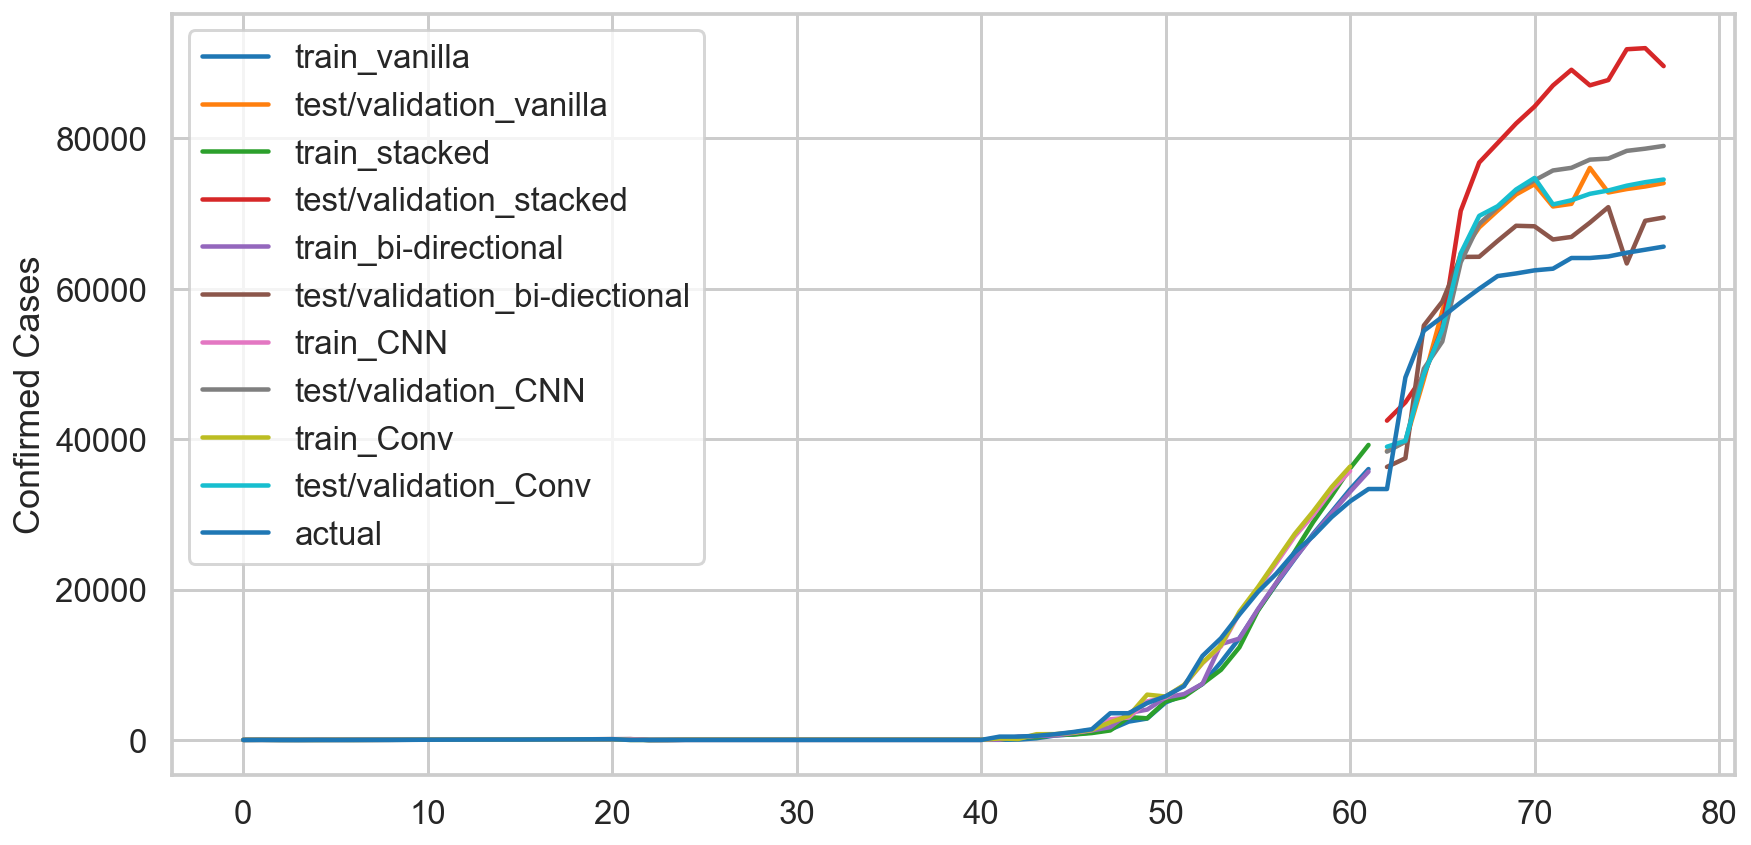

In [321]:
plt.figure(figsize=(14,7))
plt.plot(y_train_pred, label = 'train_vanilla')
plt.plot(range(len(y_train_pred), len(y)), yhat, label = 'test/validation_vanilla')
plt.plot(y_train_pred_2, label = 'train_stacked')
plt.plot(range(len(y_train_pred), len(y)), yhat_2, label = 'test/validation_stacked')
plt.plot(y_train_pred_3, label = 'train_bi-directional')
plt.plot(range(len(y_train_pred), len(y)), yhat_3, label = 'test/validation_bi-diectional')
plt.plot(y_train_pred_4, label = 'train_CNN')
plt.plot(range(len(y_train_pred), len(y)), yhat_4, label = 'test/validation_CNN')
plt.plot(y_train_pred_5, label = 'train_Conv')
plt.plot(range(len(y_train_pred), len(y)), yhat_5, label = 'test/validation_Conv')
plt.plot(y, label = 'actual')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

**Conv seems to perform slightly better than CNN, on par with vanilla, not as well as bi-directional.**

**CNN-LSTM test predictions are much closer to actual cases as compared to the other models. This may be because I am using lag = 4 instead of lag = 3 as in previous cases. Also need to offset predictions to lag.**

## China, All Provinces

China, all ~31 provinces with reported cases

In [192]:
china_df = df.loc[df['country'] == 'China'].reset_index(drop=True)
print(len(china_df.loc_id.unique()))
china_df.head()

31


,Province/State,city_county_state,country,hospital beds,physicians,GDP_per_capita,SPAR_index,IVDI_score,city_pop,effective_dist,geo_dist,ann_pass_flux,connected_airports,date,confirmed_cases,loc_id
0,Anhui,"Lianhua Community, 合肥政务文化新区, Anhui",China,4.2,1.7855,18236.612982,94.307692,0.676294,1389.908204,5.802647,483.46519,4.596527e+06,35.288462,2019-12-08,0.0,44
1,Anhui,"Lianhua Community, 合肥政务文化新区, Anhui",China,4.2,1.7855,18236.612982,94.307692,0.676294,1389.908204,5.802647,483.46519,4.596527e+06,35.288462,2019-12-09,0.0,44
2,Anhui,"Lianhua Community, 合肥政务文化新区, Anhui",China,4.2,1.7855,18236.612982,94.307692,0.676294,1389.908204,5.802647,483.46519,4.596527e+06,35.288462,2019-12-10,0.0,44
3,Anhui,"Lianhua Community, 合肥政务文化新区, Anhui",China,4.2,1.7855,18236.612982,94.307692,0.676294,1389.908204,5.802647,483.46519,4.596527e+06,35.288462,2019-12-11,0.0,44
4,Anhui,"Lianhua Community, 合肥政务文化新区, Anhui",China,4.2,1.7855,18236.612982,94.307692,0.676294,1389.908204,5.802647,483.46519,4.596527e+06,35.288462,2019-12-12,0.0,44


### Multiple input series, vanilla, lag = 3

Two or more parallel input time series and an output time series that is dependent on the input time series.

Input time series are parallel because each series has an observation at the same time steps. This applies to each of our locations reported to have a number of coronavirus cases on a given date.

- Split the data into samples maintaining the order of observations across the different input sequences.

**This is used to predict total based on multiple inputs.** Does not predict what will happen at a specific location. We can apply any type of LSTM to this data format.

In [398]:
input_seqs = {loc:array(china_df.loc[china_df.loc_id == loc].confirmed_cases) 
              for loc in china_df.loc_id.unique()}
print(input_seqs[44].shape) # loc_id = 44, 82 time steps for each location

output_seq = np.empty(0)
for i in range(len(input_seqs[44])):
    output_i = 0
    for key, val in input_seqs.items():
        output_i += val[i]
    output_seq = np.append(output_seq, output_i)
print(output_seq.shape)

# convert to [rows, columns] structure
output_seq = output_seq.reshape((len(output_seq), 1))
print(output_seq.shape)

for key, val in input_seqs.items():
    input_seqs[key] = val.reshape((len(val), 1))
print(input_seqs[44].shape)

(81,)
(81,)
(81, 1)
(81, 1)


In [399]:
# horizontally stack columns
ar = np.empty(input_seqs[44].shape)
for i in input_seqs:
    inp = input_seqs[i]
    ar = np.append(ar, inp, axis=1)

ar = np.append(ar, output_seq, axis=1)

ar.shape

(81, 33)

In [312]:
n_steps = 3

X, y = split_sequences(ar, n_steps)
print(X.shape, y.shape)

# summarize the data
# for i in range(len(X)):
#     print(X[i], y[i])

trainX = X[:int(train_size*len(X))]
trainy = y[:int(train_size*len(y))]
testX = X[int(train_size*len(X)):]
testy = y[int(train_size*len(y)):]

(79, 3, 32) (79,)


In [323]:
# Vanilla
n_features = X.shape[2]

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

Train on 62 samples, validate on 16 samples
Epoch 1/200
62/62 [==============================] - 3s 47ms/step - loss: 120115956.6452 - val_loss: 4301308928.0000
Epoch 2/200
62/62 [==============================] - 0s 307us/step - loss: 116678811.8710 - val_loss: 4188657152.0000
Epoch 3/200
62/62 [==============================] - 0s 302us/step - loss: 110988647.7419 - val_loss: 4101402624.0000
Epoch 4/200
62/62 [==============================] - 0s 383us/step - loss: 108449593.0323 - val_loss: 4001990912.0000
Epoch 5/200
62/62 [==============================] - 0s 392us/step - loss: 105643260.3871 - val_loss: 3475698432.0000
Epoch 6/200
62/62 [==============================] - 0s 524us/step - loss: 97557608.7742 - val_loss: 3405788672.0000
Epoch 7/200
62/62 [==============================] - 0s 444us/step - loss: 93799681.5484 - val_loss: 3303721984.0000
Epoch 8/200
62/62 [==============================] - 0s 318us/step - loss: 90457840.9032 - val_loss: 3216672000.0000
Epoch 9/200
62/6

Epoch 71/200
62/62 [==============================] - 0s 403us/step - loss: 1503725.2258 - val_loss: 168487680.0000
Epoch 72/200
62/62 [==============================] - 0s 361us/step - loss: 1503212.5121 - val_loss: 163847648.0000
Epoch 73/200
62/62 [==============================] - 0s 447us/step - loss: 1506072.7903 - val_loss: 167549296.0000
Epoch 74/200
62/62 [==============================] - 0s 436us/step - loss: 1498808.9879 - val_loss: 175681568.0000
Epoch 75/200
62/62 [==============================] - 0s 396us/step - loss: 1499062.3629 - val_loss: 174538928.0000
Epoch 76/200
62/62 [==============================] - 0s 331us/step - loss: 1496009.4274 - val_loss: 174988096.0000
Epoch 77/200
62/62 [==============================] - 0s 307us/step - loss: 1496486.7823 - val_loss: 175657856.0000
Epoch 78/200
62/62 [==============================] - 0s 294us/step - loss: 1492160.7036 - val_loss: 174934400.0000
Epoch 79/200
62/62 [==============================] - 0s 332us/step - lo

62/62 [==============================] - 0s 356us/step - loss: 1834013.8548 - val_loss: 53448624.0000
Epoch 142/200
62/62 [==============================] - 0s 343us/step - loss: 1917792.7742 - val_loss: 51256748.0000
Epoch 143/200
62/62 [==============================] - 0s 361us/step - loss: 1873889.2379 - val_loss: 53620976.0000
Epoch 144/200
62/62 [==============================] - 0s 454us/step - loss: 1751726.4718 - val_loss: 69259040.0000
Epoch 145/200
62/62 [==============================] - 0s 354us/step - loss: 1589465.2419 - val_loss: 82765752.0000
Epoch 146/200
62/62 [==============================] - 0s 432us/step - loss: 1465996.0242 - val_loss: 86399920.0000
Epoch 147/200
62/62 [==============================] - 0s 382us/step - loss: 1319192.0403 - val_loss: 105060832.0000
Epoch 148/200
62/62 [==============================] - 0s 372us/step - loss: 1209263.9798 - val_loss: 125884752.0000
Epoch 149/200
62/62 [==============================] - 0s 333us/step - loss: 1115525

**Loss is high compared to best univariate models.**

In [324]:
yhat_6 = model.predict(testX, verbose=1)
y_train_pred_6 = model.predict(trainX, verbose = 1)

62/62 [==============================] - 0s 103us/step


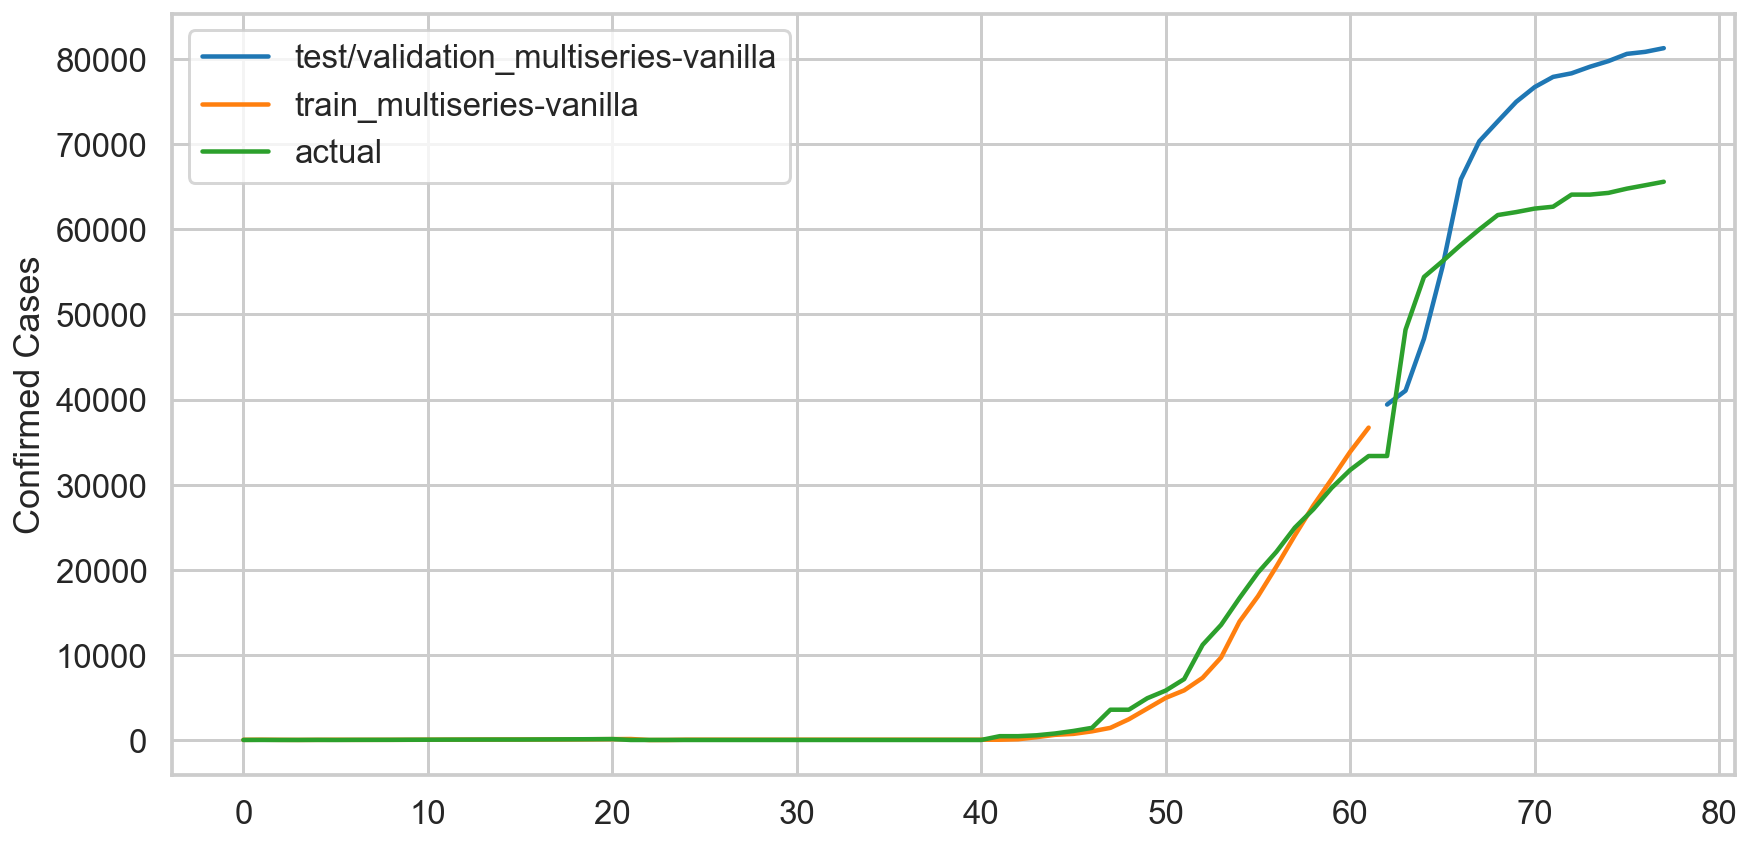

In [326]:
plt.figure(figsize=(14,7))
plt.plot(range(len(y_train_pred), len(y)), yhat_6, label = 'test/validation_multiseries-vanilla')
plt.plot(y_train_pred_6, label = 'train_multiseries-vanilla')
plt.plot(y, label = 'actual')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

### Multiple parallel series

Where there are multiple parallel time series and a value must be predicted for each - multivariate forecasting.

The main difference appears to size of dense layer, or total number of features requiring predictions.

Use the same format of data as above.

In [337]:
# Vanilla, 100 LSTMs, lag = 3

n_features = X.shape[2]

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

yhat_8 = model.predict(testX, verbose=1)
y_train_pred_8 = model.predict(trainX, verbose = 1)

Train on 62 samples, validate on 16 samples
Epoch 1/200
62/62 [==============================] - 3s 47ms/step - loss: 89800299.6129 - val_loss: 3228726784.0000
Epoch 2/200
62/62 [==============================] - 0s 319us/step - loss: 87187031.7419 - val_loss: 3166421504.0000
Epoch 3/200
62/62 [==============================] - 0s 342us/step - loss: 86476822.1935 - val_loss: 3121029632.0000
Epoch 4/200
62/62 [==============================] - 0s 698us/step - loss: 85201322.0645 - val_loss: 3032515584.0000
Epoch 5/200
62/62 [==============================] - 0s 372us/step - loss: 83683509.5484 - val_loss: 2956624896.0000
Epoch 6/200
62/62 [==============================] - 0s 357us/step - loss: 81186472.7742 - val_loss: 2808981504.0000
Epoch 7/200
62/62 [==============================] - 0s 377us/step - loss: 77933833.2903 - val_loss: 2591361536.0000
Epoch 8/200
62/62 [==============================] - 0s 365us/step - loss: 73994315.8710 - val_loss: 2413250560.0000
Epoch 9/200
62/62 [==

62/62 [==============================] - 0s 429us/step - loss: 1457374.5524 - val_loss: 131042272.0000
Epoch 72/200
62/62 [==============================] - 0s 499us/step - loss: 1468841.9476 - val_loss: 110812832.0000
Epoch 73/200
62/62 [==============================] - 0s 504us/step - loss: 1467149.8206 - val_loss: 98503040.0000
Epoch 74/200
62/62 [==============================] - 0s 411us/step - loss: 1564840.9879 - val_loss: 105189984.0000
Epoch 75/200
62/62 [==============================] - 0s 551us/step - loss: 1467751.0968 - val_loss: 126952896.0000
Epoch 76/200
62/62 [==============================] - 0s 416us/step - loss: 1468312.0363 - val_loss: 117233144.0000
Epoch 77/200
62/62 [==============================] - 0s 418us/step - loss: 1462815.8750 - val_loss: 113832544.0000
Epoch 78/200
62/62 [==============================] - 0s 444us/step - loss: 1460512.8044 - val_loss: 110725936.0000
Epoch 79/200
62/62 [==============================] - 0s 436us/step - loss: 1454683.27

62/62 [==============================] - 0s 460us/step - loss: 1325513.9476 - val_loss: 160829568.0000
Epoch 142/200
62/62 [==============================] - 0s 469us/step - loss: 1332229.6129 - val_loss: 149334016.0000
Epoch 143/200
62/62 [==============================] - 0s 412us/step - loss: 1335864.4395 - val_loss: 145067184.0000
Epoch 144/200
62/62 [==============================] - 0s 429us/step - loss: 1251306.6935 - val_loss: 150465776.0000
Epoch 145/200
62/62 [==============================] - 0s 430us/step - loss: 1212485.1573 - val_loss: 148783056.0000
Epoch 146/200
62/62 [==============================] - 0s 321us/step - loss: 1195107.2157 - val_loss: 146648928.0000
Epoch 147/200
62/62 [==============================] - 0s 388us/step - loss: 1203954.5343 - val_loss: 148679456.0000
Epoch 148/200
62/62 [==============================] - 0s 437us/step - loss: 1184566.6532 - val_loss: 154844384.0000
Epoch 149/200
62/62 [==============================] - 0s 429us/step - loss: 1

In [338]:
# Stacked, 100 LSTMs, lag = 3

n_features = X.shape[2]

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

yhat_7 = model.predict(testX, verbose=1)
y_train_pred_7 = model.predict(trainX, verbose = 1)

Train on 62 samples, validate on 16 samples
Epoch 1/200
62/62 [==============================] - 3s 54ms/step - loss: 93477296.5161 - val_loss: 3339173888.0000
Epoch 2/200
62/62 [==============================] - 0s 563us/step - loss: 90292401.0323 - val_loss: 3281580800.0000
Epoch 3/200
62/62 [==============================] - 0s 697us/step - loss: 86391500.9032 - val_loss: 3101777920.0000
Epoch 4/200
62/62 [==============================] - 0s 562us/step - loss: 84414012.6452 - val_loss: 3005681152.0000
Epoch 5/200
62/62 [==============================] - 0s 461us/step - loss: 81184803.0968 - val_loss: 2809109504.0000
Epoch 6/200
62/62 [==============================] - 0s 549us/step - loss: 77809486.1935 - val_loss: 2632930048.0000
Epoch 7/200
62/62 [==============================] - 0s 644us/step - loss: 74051789.4194 - val_loss: 2532375808.0000
Epoch 8/200
62/62 [==============================] - 0s 737us/step - loss: 71403345.4194 - val_loss: 2336746496.0000
Epoch 9/200
62/62 [==

62/62 [==============================] - 0s 680us/step - loss: 1620223.6210 - val_loss: 168385584.0000
Epoch 72/200
62/62 [==============================] - 0s 596us/step - loss: 1641676.8145 - val_loss: 140749984.0000
Epoch 73/200
62/62 [==============================] - 0s 448us/step - loss: 1601755.0161 - val_loss: 106726576.0000
Epoch 74/200
62/62 [==============================] - 0s 514us/step - loss: 1610246.6613 - val_loss: 91655264.0000
Epoch 75/200
62/62 [==============================] - 0s 515us/step - loss: 1598008.6532 - val_loss: 96811536.0000
Epoch 76/200
62/62 [==============================] - 0s 466us/step - loss: 1591826.9032 - val_loss: 101282016.0000
Epoch 77/200
62/62 [==============================] - 0s 447us/step - loss: 1573559.9194 - val_loss: 103615248.0000
Epoch 78/200
62/62 [==============================] - 0s 448us/step - loss: 1511202.2056 - val_loss: 22962856.0000
Epoch 79/200
62/62 [==============================] - 0s 447us/step - loss: 1338056.3105

62/62 [==============================] - 0s 507us/step - loss: 911916.6754 - val_loss: 123644240.0000
Epoch 142/200
62/62 [==============================] - 0s 563us/step - loss: 808522.6331 - val_loss: 113698080.0000
Epoch 143/200
62/62 [==============================] - 0s 495us/step - loss: 907334.5706 - val_loss: 54367440.0000
Epoch 144/200
62/62 [==============================] - 0s 500us/step - loss: 958503.7319 - val_loss: 26668884.0000
Epoch 145/200
62/62 [==============================] - 0s 546us/step - loss: 914496.9274 - val_loss: 113857568.0000
Epoch 146/200
62/62 [==============================] - 0s 492us/step - loss: 927099.1028 - val_loss: 152506992.0000
Epoch 147/200
62/62 [==============================] - 0s 471us/step - loss: 937723.9839 - val_loss: 176229536.0000
Epoch 148/200
62/62 [==============================] - 0s 505us/step - loss: 1002182.7863 - val_loss: 139166416.0000
Epoch 149/200
62/62 [==============================] - 0s 517us/step - loss: 905029.915

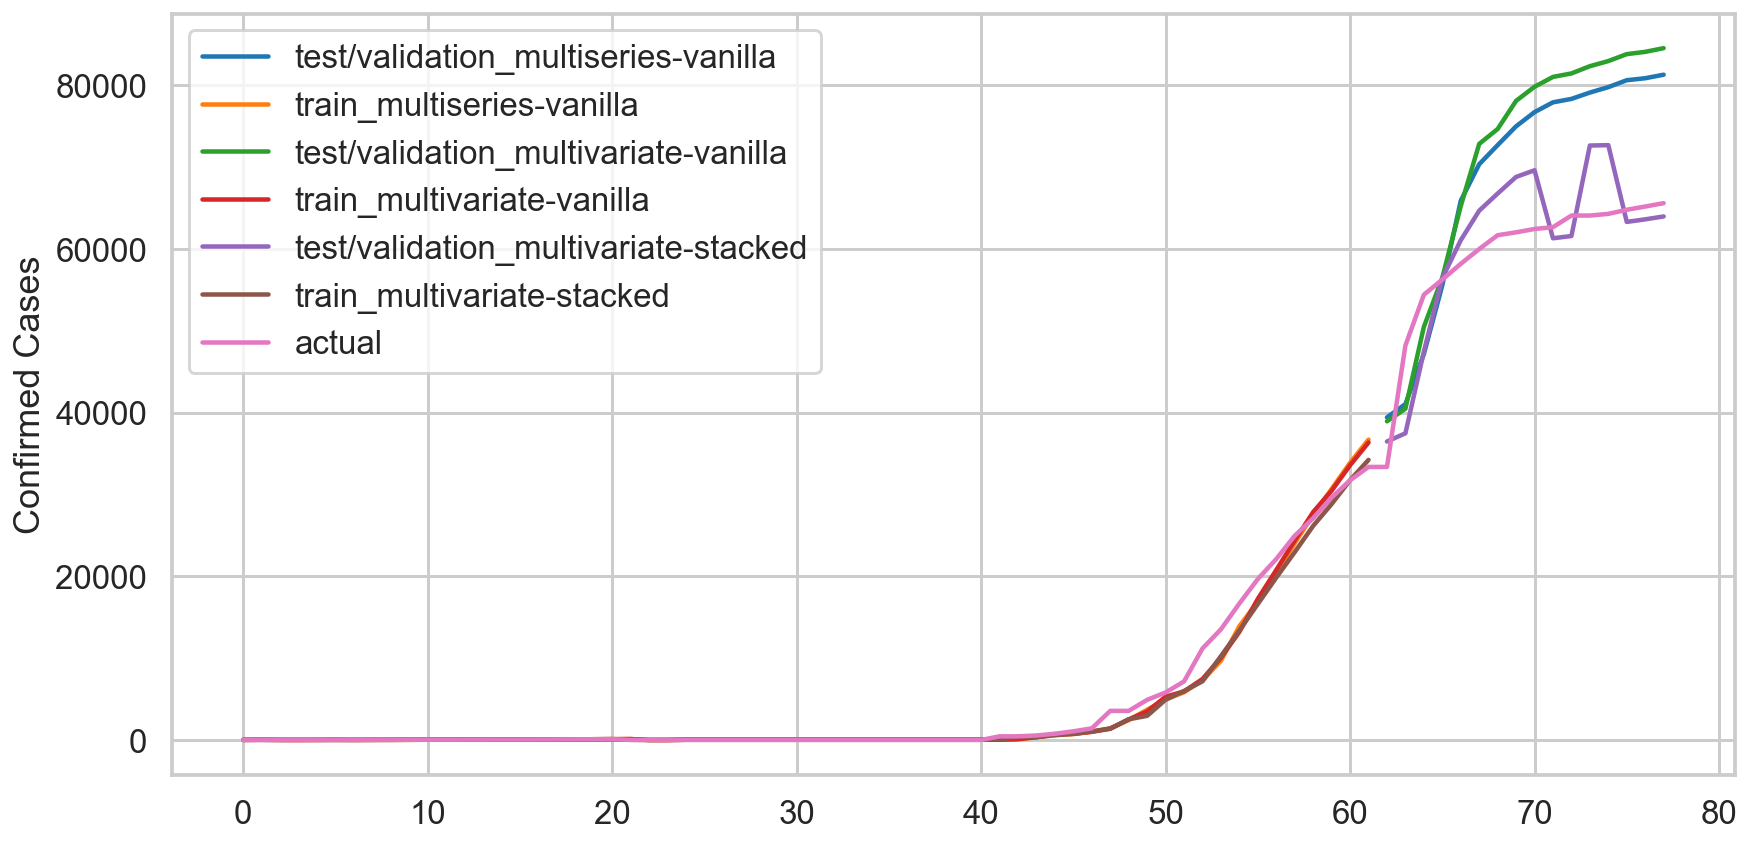

In [339]:
plt.figure(figsize=(14,7))
plt.plot(range(len(y_train_pred), len(y)), yhat_6, label = 'test/validation_multiseries-vanilla')
plt.plot(y_train_pred_6, label = 'train_multiseries-vanilla')
plt.plot(range(len(y_train_pred), len(y)), yhat_8, label = 'test/validation_multivariate-vanilla')
plt.plot(y_train_pred_8, label = 'train_multivariate-vanilla')
plt.plot(range(len(y_train_pred), len(y)), yhat_7, label = 'test/validation_multivariate-stacked')
plt.plot(y_train_pred_7, label = 'train_multivariate-stacked')
plt.plot(y, label = 'actual')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

In [341]:
yhat_7

array([[36469.41 ],
       [37473.81 ],
       [47456.617],
       [56436.87 ],
       [61063.2  ],
       [64677.855],
       [66771.65 ],
       [68802.37 ],
       [69616.57 ],
       [61304.727],
       [61582.598],
       [72637.68 ],
       [72686.61 ],
       [63305.617],
       [63620.113],
       [63973.473]], dtype=float32)

In this example we are still predicting total cases in China by first predicting cases per location.

## Univariate Multi-Step

Predicting multiple time steps into the future. 

In [379]:
seq = hubei_df.confirmed_cases # start with univariate

n_steps_in, n_steps_out = 3, 2

X, y = split_sequence_multistep(seq, n_steps_in, n_steps_out)

# summarize the data
# for i in range(len(X)):
#     print(X[i], y[i])

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

trainX = X[:int(train_size*len(X))]
trainy = y[:int(train_size*len(y))]
testX = X[int(train_size*len(X)):]
testy = y[int(train_size*len(y)):]

In [380]:
trainX.shape

(61, 3, 1)

### Vector Output

In [381]:
# Stacked
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [382]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 3, 100)            40800     
_________________________________________________________________
lstm_44 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_37 (Dense)             (None, 2)                 202       
Total params: 121,402
Trainable params: 121,402
Non-trainable params: 0
_________________________________________________________________


In [383]:
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

Train on 61 samples, validate on 16 samples
Epoch 1/200
61/61 [==============================] - 4s 73ms/step - loss: 88448590.2951 - val_loss: 3424561920.0000
Epoch 2/200
61/61 [==============================] - 0s 634us/step - loss: 87572580.9836 - val_loss: 3408214784.0000
Epoch 3/200
61/61 [==============================] - 0s 690us/step - loss: 87241756.6557 - val_loss: 3389490176.0000
Epoch 4/200
61/61 [==============================] - 0s 731us/step - loss: 86702488.7869 - val_loss: 3351252736.0000
Epoch 5/200
61/61 [==============================] - 0s 692us/step - loss: 85580808.0000 - val_loss: 3319981056.0000
Epoch 6/200
61/61 [==============================] - 0s 545us/step - loss: 84735987.4098 - val_loss: 3258683648.0000
Epoch 7/200
61/61 [==============================] - 0s 539us/step - loss: 83306117.2459 - val_loss: 3204780032.0000
Epoch 8/200
61/61 [==============================] - 0s 822us/step - loss: 82585561.4426 - val_loss: 3115282432.0000
Epoch 9/200
61/61 [==

61/61 [==============================] - 0s 657us/step - loss: 3035096.3443 - val_loss: 501394176.0000
Epoch 72/200
61/61 [==============================] - 0s 566us/step - loss: 2758472.8525 - val_loss: 333042720.0000
Epoch 73/200
61/61 [==============================] - 0s 582us/step - loss: 2878279.2213 - val_loss: 337181440.0000
Epoch 74/200
61/61 [==============================] - 0s 740us/step - loss: 2733777.6127 - val_loss: 319043648.0000
Epoch 75/200
61/61 [==============================] - 0s 745us/step - loss: 2637204.6988 - val_loss: 340585856.0000
Epoch 76/200
61/61 [==============================] - 0s 776us/step - loss: 2657063.3484 - val_loss: 332033440.0000
Epoch 77/200
61/61 [==============================] - 0s 679us/step - loss: 2625571.2500 - val_loss: 347708064.0000
Epoch 78/200
61/61 [==============================] - 0s 763us/step - loss: 2550794.9467 - val_loss: 338673984.0000
Epoch 79/200
61/61 [==============================] - 0s 674us/step - loss: 2717598.6

61/61 [==============================] - 0s 603us/step - loss: 1477484.2992 - val_loss: 132955120.0000
Epoch 142/200
61/61 [==============================] - 0s 574us/step - loss: 1447387.0758 - val_loss: 130123144.0000
Epoch 143/200
61/61 [==============================] - 0s 633us/step - loss: 1436087.2848 - val_loss: 126778984.0000
Epoch 144/200
61/61 [==============================] - 0s 616us/step - loss: 1441478.2848 - val_loss: 125573024.0000
Epoch 145/200
61/61 [==============================] - 0s 650us/step - loss: 1338946.1373 - val_loss: 136245952.0000
Epoch 146/200
61/61 [==============================] - 0s 649us/step - loss: 1373240.5943 - val_loss: 150529760.0000
Epoch 147/200
61/61 [==============================] - 0s 582us/step - loss: 1405137.1598 - val_loss: 129532528.0000
Epoch 148/200
61/61 [==============================] - 0s 621us/step - loss: 1381905.0902 - val_loss: 129774696.0000
Epoch 149/200
61/61 [==============================] - 0s 686us/step - loss: 1

In [384]:
yhat_9 = model.predict(testX, verbose=1)
y_train_pred_9 = model.predict(trainX, verbose = 1)

61/61 [==============================] - 0s 169us/step


In [385]:
# Vanilla
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [386]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 202       
Total params: 41,002
Trainable params: 41,002
Non-trainable params: 0
_________________________________________________________________


In [387]:
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

yhat_10 = model.predict(testX, verbose=1)
y_train_pred_10 = model.predict(trainX, verbose = 1)

Train on 61 samples, validate on 16 samples
Epoch 1/200
61/61 [==============================] - 4s 63ms/step - loss: 84514365.5082 - val_loss: 3160479232.0000
Epoch 2/200
61/61 [==============================] - 0s 379us/step - loss: 81178518.2951 - val_loss: 3016621056.0000
Epoch 3/200
61/61 [==============================] - 0s 429us/step - loss: 78584015.8033 - val_loss: 2938279168.0000
Epoch 4/200
61/61 [==============================] - 0s 382us/step - loss: 75799361.7049 - val_loss: 2627264512.0000
Epoch 5/200
61/61 [==============================] - 0s 470us/step - loss: 71611925.2459 - val_loss: 2304095232.0000
Epoch 6/200
61/61 [==============================] - 0s 380us/step - loss: 67886419.8033 - val_loss: 2429728768.0000
Epoch 7/200
61/61 [==============================] - 0s 419us/step - loss: 66982809.8361 - val_loss: 2350622208.0000
Epoch 8/200
61/61 [==============================] - 0s 414us/step - loss: 64479984.6557 - val_loss: 1883568128.0000
Epoch 9/200
61/61 [==

61/61 [==============================] - 0s 432us/step - loss: 2140266.8566 - val_loss: 261218480.0000
Epoch 72/200
61/61 [==============================] - 0s 407us/step - loss: 2135241.8197 - val_loss: 258094112.0000
Epoch 73/200
61/61 [==============================] - 0s 476us/step - loss: 2135689.2992 - val_loss: 252735696.0000
Epoch 74/200
61/61 [==============================] - 0s 451us/step - loss: 2134076.0758 - val_loss: 253435744.0000
Epoch 75/200
61/61 [==============================] - 0s 372us/step - loss: 2123244.0999 - val_loss: 251835840.0000
Epoch 76/200
61/61 [==============================] - 0s 442us/step - loss: 2119507.2582 - val_loss: 252305376.0000
Epoch 77/200
61/61 [==============================] - 0s 459us/step - loss: 2116099.7787 - val_loss: 253341088.0000
Epoch 78/200
61/61 [==============================] - 0s 411us/step - loss: 2106852.8402 - val_loss: 253067888.0000
Epoch 79/200
61/61 [==============================] - 0s 400us/step - loss: 2102603.3

61/61 [==============================] - 0s 429us/step - loss: 1822569.1516 - val_loss: 184731872.0000
Epoch 142/200
61/61 [==============================] - 0s 372us/step - loss: 1823030.0779 - val_loss: 207156544.0000
Epoch 143/200
61/61 [==============================] - 0s 393us/step - loss: 1822771.5430 - val_loss: 232932272.0000
Epoch 144/200
61/61 [==============================] - 0s 364us/step - loss: 1821308.5984 - val_loss: 224571120.0000
Epoch 145/200
61/61 [==============================] - 0s 376us/step - loss: 1806022.7828 - val_loss: 223934496.0000
Epoch 146/200
61/61 [==============================] - 0s 394us/step - loss: 1797373.8648 - val_loss: 220245664.0000
Epoch 147/200
61/61 [==============================] - 0s 397us/step - loss: 1793356.6148 - val_loss: 216401472.0000
Epoch 148/200
61/61 [==============================] - 0s 375us/step - loss: 1792727.0389 - val_loss: 217239248.0000
Epoch 149/200
61/61 [==============================] - 0s 439us/step - loss: 1

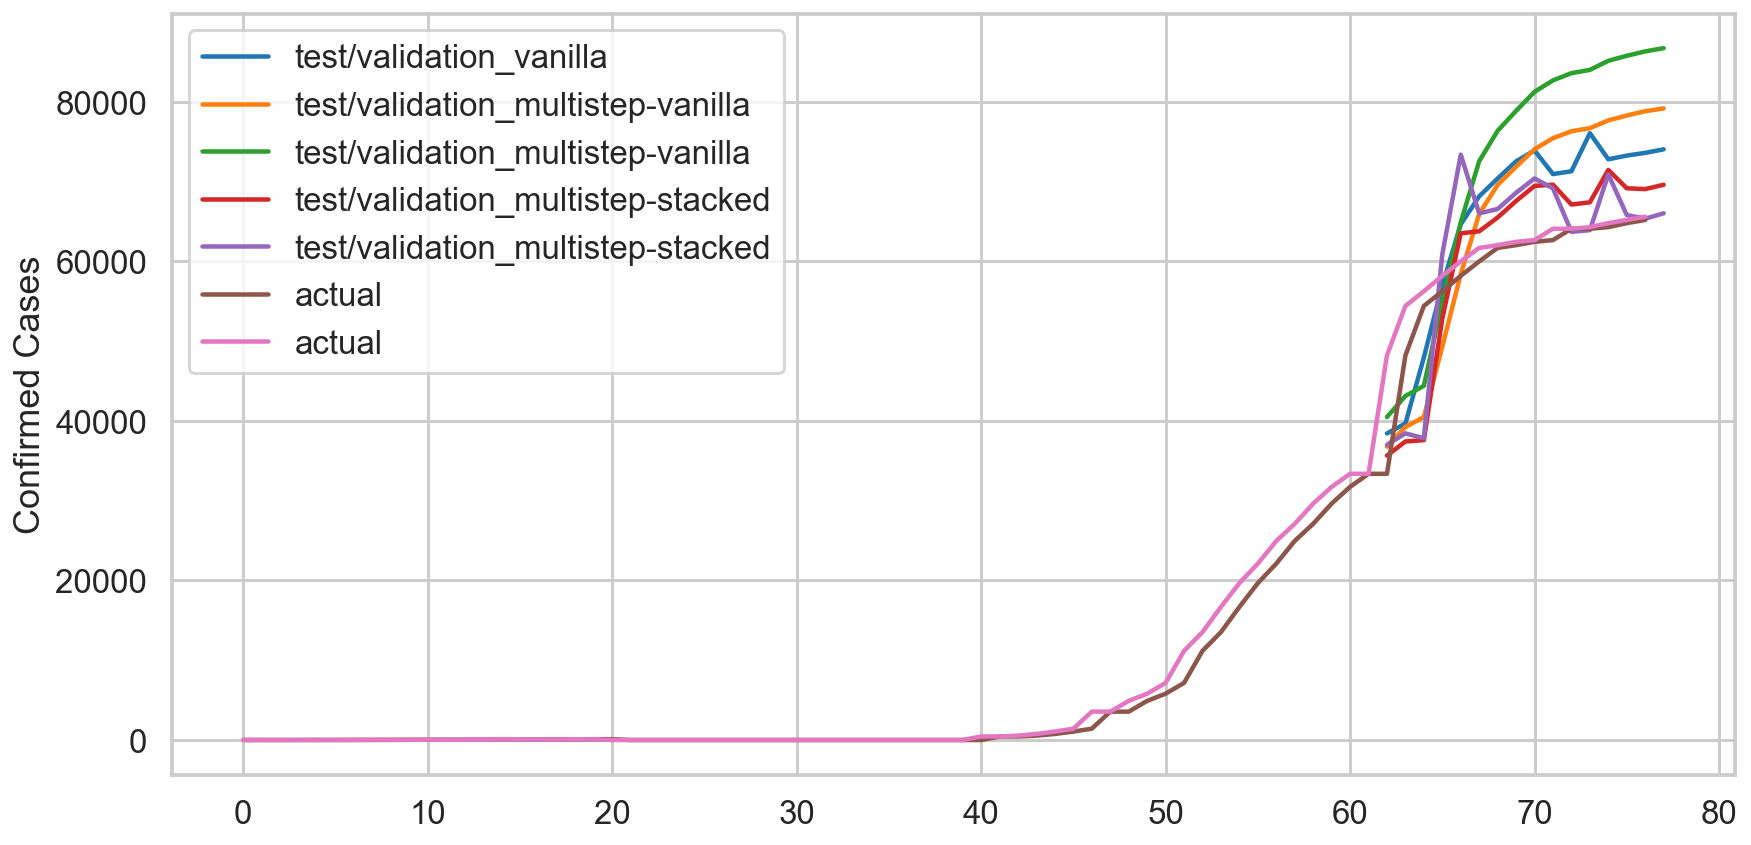

In [391]:
plt.figure(figsize=(14,7))
plt.plot(range(len(y_train_pred), len(y)+1), yhat, label = 'test/validation_vanilla')
# plt.plot(y_train_pred, label = 'train_vanilla')
plt.plot(range(len(y_train_pred), len(y)+1), yhat_10, label = 'test/validation_multistep-vanilla')
# plt.plot(y_train_pred_10, label = 'train_multistep-vanilla')
plt.plot(range(len(y_train_pred), len(y)+1), yhat_9, label = 'test/validation_multistep-stacked')
# plt.plot(y_train_pred_9, label = 'train_multistep-stacked')
plt.plot(y, label = 'actual')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

In [393]:
yhat_10

array([[36775.844, 40485.33 ],
       [39227.605, 43123.562],
       [40486.875, 44393.07 ],
       [49300.543, 54920.688],
       [58386.684, 64890.445],
       [65953.18 , 72552.61 ],
       [69580.05 , 76365.23 ],
       [71858.37 , 78856.19 ],
       [74053.63 , 81248.766],
       [75436.27 , 82682.86 ],
       [76304.086, 83586.07 ],
       [76686.26 , 83996.11 ],
       [77667.84 , 85131.31 ],
       [78278.22 , 85764.86 ],
       [78817.625, 86313.48 ],
       [79166.69 , 86719.95 ]], dtype=float32)

In [395]:
y[-16:]

array([[33366., 33366.],
       [33366., 48206.],
       [48206., 54406.],
       [54406., 56249.],
       [56249., 58182.],
       [58182., 59989.],
       [59989., 61682.],
       [61682., 62031.],
       [62031., 62442.],
       [62442., 62662.],
       [62662., 64084.],
       [64084., 64084.],
       [64084., 64287.],
       [64287., 64786.],
       [64786., 65187.],
       [65187., 65596.]])

### Encoder-Decoder

Forecasting variable length output sequences - not needed in this case

## Multivariate Multi-Step

### Multiple Input, Multi-Step Output

Assumes no relationship among provinces.

In [400]:
# 'ar' is a column stack of all china province time series, last column = sum all time points for each location 

n_steps_in, n_steps_out = 3, 2
dataset = ar
X, y = split_sequences_multistep(dataset, n_steps_in, n_steps_out)

n_features = X.shape[2] # number of provinces

trainX = X[:int(train_size*len(X))]
trainy = y[:int(train_size*len(y))]
testX = X[int(train_size*len(X)):]
testy = y[int(train_size*len(y)):]

# Stacked
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

yhat_11 = model.predict(testX, verbose=1)
y_train_pred_11 = model.predict(trainX, verbose = 1)

Train on 62 samples, validate on 16 samples
Epoch 1/200
62/62 [==============================] - 5s 75ms/step - loss: 159653101.4194 - val_loss: 4973594112.0000
Epoch 2/200
62/62 [==============================] - 0s 645us/step - loss: 159133452.6452 - val_loss: 4917453312.0000
Epoch 3/200
62/62 [==============================] - 0s 656us/step - loss: 155892164.6452 - val_loss: 4723893760.0000
Epoch 4/200
62/62 [==============================] - 0s 633us/step - loss: 154992716.9032 - val_loss: 4478444544.0000
Epoch 5/200
62/62 [==============================] - 0s 634us/step - loss: 153373734.1935 - val_loss: 4325367296.0000
Epoch 6/200
62/62 [==============================] - 0s 658us/step - loss: 144648701.4194 - val_loss: 4151736832.0000
Epoch 7/200
62/62 [==============================] - 0s 753us/step - loss: 141385695.4839 - val_loss: 4051640832.0000
Epoch 8/200
62/62 [==============================] - 0s 651us/step - loss: 136762511.4839 - val_loss: 3598446592.0000
Epoch 9/200
6

62/62 [==============================] - 0s 822us/step - loss: 1112454.5605 - val_loss: 155133408.0000
Epoch 72/200
62/62 [==============================] - 0s 895us/step - loss: 1154541.7702 - val_loss: 158214144.0000
Epoch 73/200
62/62 [==============================] - 0s 619us/step - loss: 1207111.8145 - val_loss: 155767984.0000
Epoch 74/200
62/62 [==============================] - 0s 622us/step - loss: 1295686.1210 - val_loss: 164238560.0000
Epoch 75/200
62/62 [==============================] - 0s 821us/step - loss: 1317140.2198 - val_loss: 155159328.0000
Epoch 76/200
62/62 [==============================] - 0s 737us/step - loss: 1329251.2278 - val_loss: 148199808.0000
Epoch 77/200
62/62 [==============================] - 0s 802us/step - loss: 1363841.8589 - val_loss: 140578896.0000
Epoch 78/200
62/62 [==============================] - 0s 721us/step - loss: 1498167.3911 - val_loss: 136966640.0000
Epoch 79/200
62/62 [==============================] - 0s 858us/step - loss: 1310600.5

62/62 [==============================] - 0s 647us/step - loss: 259360.6794 - val_loss: 47493628.0000
Epoch 143/200
62/62 [==============================] - 0s 640us/step - loss: 246469.7752 - val_loss: 53084288.0000
Epoch 144/200
62/62 [==============================] - 0s 644us/step - loss: 239330.0464 - val_loss: 56923312.0000
Epoch 145/200
62/62 [==============================] - 0s 706us/step - loss: 246259.7505 - val_loss: 56837040.0000
Epoch 146/200
62/62 [==============================] - 0s 641us/step - loss: 248754.0862 - val_loss: 52650768.0000
Epoch 147/200
62/62 [==============================] - 0s 649us/step - loss: 246612.2772 - val_loss: 54140208.0000
Epoch 148/200
62/62 [==============================] - 0s 651us/step - loss: 245569.4980 - val_loss: 52084008.0000
Epoch 149/200
62/62 [==============================] - 0s 660us/step - loss: 249003.3105 - val_loss: 53353364.0000
Epoch 150/200
62/62 [==============================] - 0s 633us/step - loss: 237036.6270 - val

**This is the lowest loss of all models so far.**

### Multiple Parallel Input, Multi-Step Output

In [403]:
dataset = ar

n_steps_in, n_steps_out = 3, 2

X, y = split_sequences_multistep(dataset, n_steps_in, n_steps_out)

n_features = X.shape[2]

trainX = X[:int(train_size*len(X))]
trainy = y[:int(train_size*len(y))]
testX = X[int(train_size*len(X)):]
testy = y[int(train_size*len(y)):]

# Stacked
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.fit(trainX, trainy, epochs=200, verbose=1, validation_data = (testX, testy))

yhat_12 = model.predict(testX, verbose=1)
y_train_pred_12 = model.predict(trainX, verbose = 1)

Train on 62 samples, validate on 16 samples
Epoch 1/200
62/62 [==============================] - 4s 71ms/step - loss: 162301681.2903 - val_loss: 4945119232.0000
Epoch 2/200
62/62 [==============================] - 0s 544us/step - loss: 159958462.4516 - val_loss: 4842165248.0000
Epoch 3/200
62/62 [==============================] - 0s 741us/step - loss: 159175030.4516 - val_loss: 4866066432.0000
Epoch 4/200
62/62 [==============================] - 0s 683us/step - loss: 157540277.1613 - val_loss: 4761122816.0000
Epoch 5/200
62/62 [==============================] - 0s 683us/step - loss: 154202032.5161 - val_loss: 4678981120.0000
Epoch 6/200
62/62 [==============================] - 0s 633us/step - loss: 152804664.0000 - val_loss: 4651025920.0000
Epoch 7/200
62/62 [==============================] - 0s 626us/step - loss: 149896200.2581 - val_loss: 4539082240.0000
Epoch 8/200
62/62 [==============================] - 0s 741us/step - loss: 147548352.5161 - val_loss: 4383941632.0000
Epoch 9/200
6

62/62 [==============================] - 0s 677us/step - loss: 1008362.7762 - val_loss: 97503984.0000
Epoch 72/200
62/62 [==============================] - 0s 651us/step - loss: 1239756.4395 - val_loss: 122088192.0000
Epoch 73/200
62/62 [==============================] - 0s 678us/step - loss: 1706468.8790 - val_loss: 120725688.0000
Epoch 74/200
62/62 [==============================] - 0s 582us/step - loss: 1326753.8952 - val_loss: 81920400.0000
Epoch 75/200
62/62 [==============================] - 0s 622us/step - loss: 806332.8669 - val_loss: 34780072.0000
Epoch 76/200
62/62 [==============================] - 0s 695us/step - loss: 964784.8790 - val_loss: 22189256.0000
Epoch 77/200
62/62 [==============================] - 0s 742us/step - loss: 5459768.7097 - val_loss: 39351748.0000
Epoch 78/200
62/62 [==============================] - 0s 744us/step - loss: 2982921.7661 - val_loss: 79941800.0000
Epoch 79/200
62/62 [==============================] - 0s 818us/step - loss: 1814131.7016 - va

Epoch 142/200
62/62 [==============================] - 0s 858us/step - loss: 428307.4536 - val_loss: 23363436.0000
Epoch 143/200
62/62 [==============================] - 0s 653us/step - loss: 894936.6048 - val_loss: 55350016.0000
Epoch 144/200
62/62 [==============================] - 0s 678us/step - loss: 1106649.2117 - val_loss: 22506858.0000
Epoch 145/200
62/62 [==============================] - 0s 787us/step - loss: 299258.7883 - val_loss: 22935948.0000
Epoch 146/200
62/62 [==============================] - 0s 748us/step - loss: 929083.1230 - val_loss: 26944906.0000
Epoch 147/200
62/62 [==============================] - 0s 714us/step - loss: 788222.2762 - val_loss: 20444432.0000
Epoch 148/200
62/62 [==============================] - 0s 688us/step - loss: 381457.9062 - val_loss: 20745608.0000
Epoch 149/200
62/62 [==============================] - 0s 757us/step - loss: 342927.8810 - val_loss: 25787160.0000
Epoch 150/200
62/62 [==============================] - 0s 870us/step - loss: 31

**This model has even better loss!**

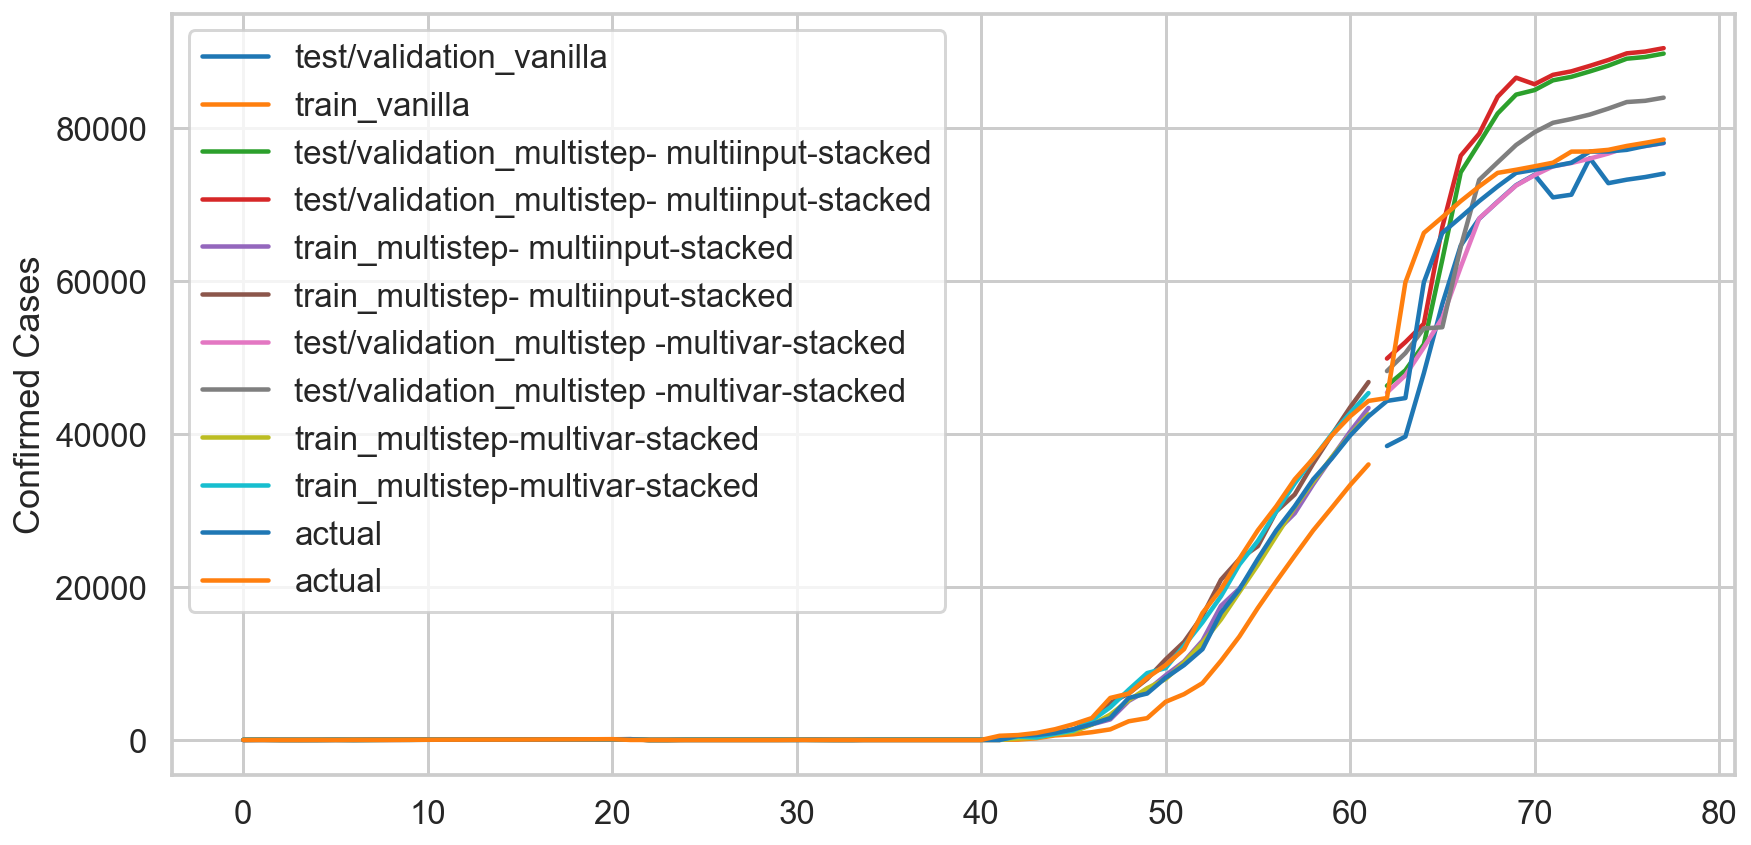

In [405]:
plt.figure(figsize=(14,7))
plt.plot(range(len(y_train_pred), len(y)), yhat, label = 'test/validation_vanilla')
plt.plot(y_train_pred, label = 'train_vanilla')
plt.plot(range(len(y_train_pred), len(y)), yhat_11, label = 'test/validation_multistep- multiinput-stacked')
plt.plot(y_train_pred_11, label = 'train_multistep- multiinput-stacked')
plt.plot(range(len(y_train_pred), len(y)), yhat_12, label = 'test/validation_multistep -multivar-stacked')
plt.plot(y_train_pred_12, label = 'train_multistep-multivar-stacked')
plt.plot(y, label = 'actual')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

## Multi-step Multivariate Conv2D, lag = 3

### China

In [409]:
dataset = ar

n_steps_in, n_steps_out = 4, 2

X, y = split_sequences_multistep(ar, n_steps_in, n_steps_out)
X.shape

(77, 4, 32)

In [419]:
n_features = X.shape[2]
n_seq = 2

trainX = X[:int(train_size*len(X))]
trainy = y[:int(train_size*len(y))]
testX = X[int(train_size*len(X)):]
testy = y[int(train_size*len(y)):]

# Stacked
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps_out, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_8 (ConvLSTM2D)  (None, 1, 1, 64)          33536     
_________________________________________________________________
flatten_13 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [420]:
model.fit(trainX, trainy, epochs=200, verbose=1, validation_split = 0.1)

yhat_13 = model.predict(testX, verbose=1)
y_train_pred_13 = model.predict(trainX, verbose = 1)

Train on 54 samples, validate on 7 samples
Epoch 1/200
54/54 [==============================] - 5s 102ms/step - loss: 13651506.6759 - val_loss: 764085568.0000
Epoch 2/200
54/54 [==============================] - 0s 390us/step - loss: 13329736.4444 - val_loss: 736791616.0000
Epoch 3/200
54/54 [==============================] - 0s 353us/step - loss: 13177142.0000 - val_loss: 706068352.0000
Epoch 4/200
54/54 [==============================] - 0s 820us/step - loss: 12960846.7407 - val_loss: 679468928.0000
Epoch 5/200
54/54 [==============================] - 0s 605us/step - loss: 12732646.7037 - val_loss: 648769536.0000
Epoch 6/200
54/54 [==============================] - 0s 427us/step - loss: 12511333.7778 - val_loss: 635232064.0000
Epoch 7/200
54/54 [==============================] - 0s 394us/step - loss: 12327706.5370 - val_loss: 625508224.0000
Epoch 8/200
54/54 [==============================] - 0s 384us/step - loss: 12063416.4074 - val_loss: 614522304.0000
Epoch 9/200
54/54 [==========

54/54 [==============================] - 0s 418us/step - loss: 144021.7766 - val_loss: 196642016.0000
Epoch 72/200
54/54 [==============================] - 0s 418us/step - loss: 144087.9253 - val_loss: 194553184.0000
Epoch 73/200
54/54 [==============================] - 0s 416us/step - loss: 143903.2118 - val_loss: 192597264.0000
Epoch 74/200
54/54 [==============================] - 0s 327us/step - loss: 143777.8704 - val_loss: 189675744.0000
Epoch 75/200
54/54 [==============================] - 0s 448us/step - loss: 143561.6891 - val_loss: 186120048.0000
Epoch 76/200
54/54 [==============================] - 0s 360us/step - loss: 142925.6286 - val_loss: 184905328.0000
Epoch 77/200
54/54 [==============================] - 0s 435us/step - loss: 142729.8389 - val_loss: 185351456.0000
Epoch 78/200
54/54 [==============================] - 0s 354us/step - loss: 142793.4465 - val_loss: 185787936.0000
Epoch 79/200
54/54 [==============================] - 0s 369us/step - loss: 141218.6291 - val

Epoch 142/200
54/54 [==============================] - 0s 509us/step - loss: 122701.7627 - val_loss: 158451040.0000
Epoch 143/200
54/54 [==============================] - 0s 479us/step - loss: 121305.6953 - val_loss: 178517424.0000
Epoch 144/200
54/54 [==============================] - 0s 338us/step - loss: 121294.9699 - val_loss: 178807408.0000
Epoch 145/200
54/54 [==============================] - 0s 404us/step - loss: 121184.1377 - val_loss: 179876336.0000
Epoch 146/200
54/54 [==============================] - 0s 445us/step - loss: 120996.8662 - val_loss: 181449056.0000
Epoch 147/200
54/54 [==============================] - 0s 467us/step - loss: 120883.3657 - val_loss: 183394960.0000
Epoch 148/200
54/54 [==============================] - 0s 536us/step - loss: 120428.6202 - val_loss: 182542608.0000
Epoch 149/200
54/54 [==============================] - 0s 379us/step - loss: 120547.7025 - val_loss: 186074912.0000
Epoch 150/200
54/54 [==============================] - 0s 414us/step - l

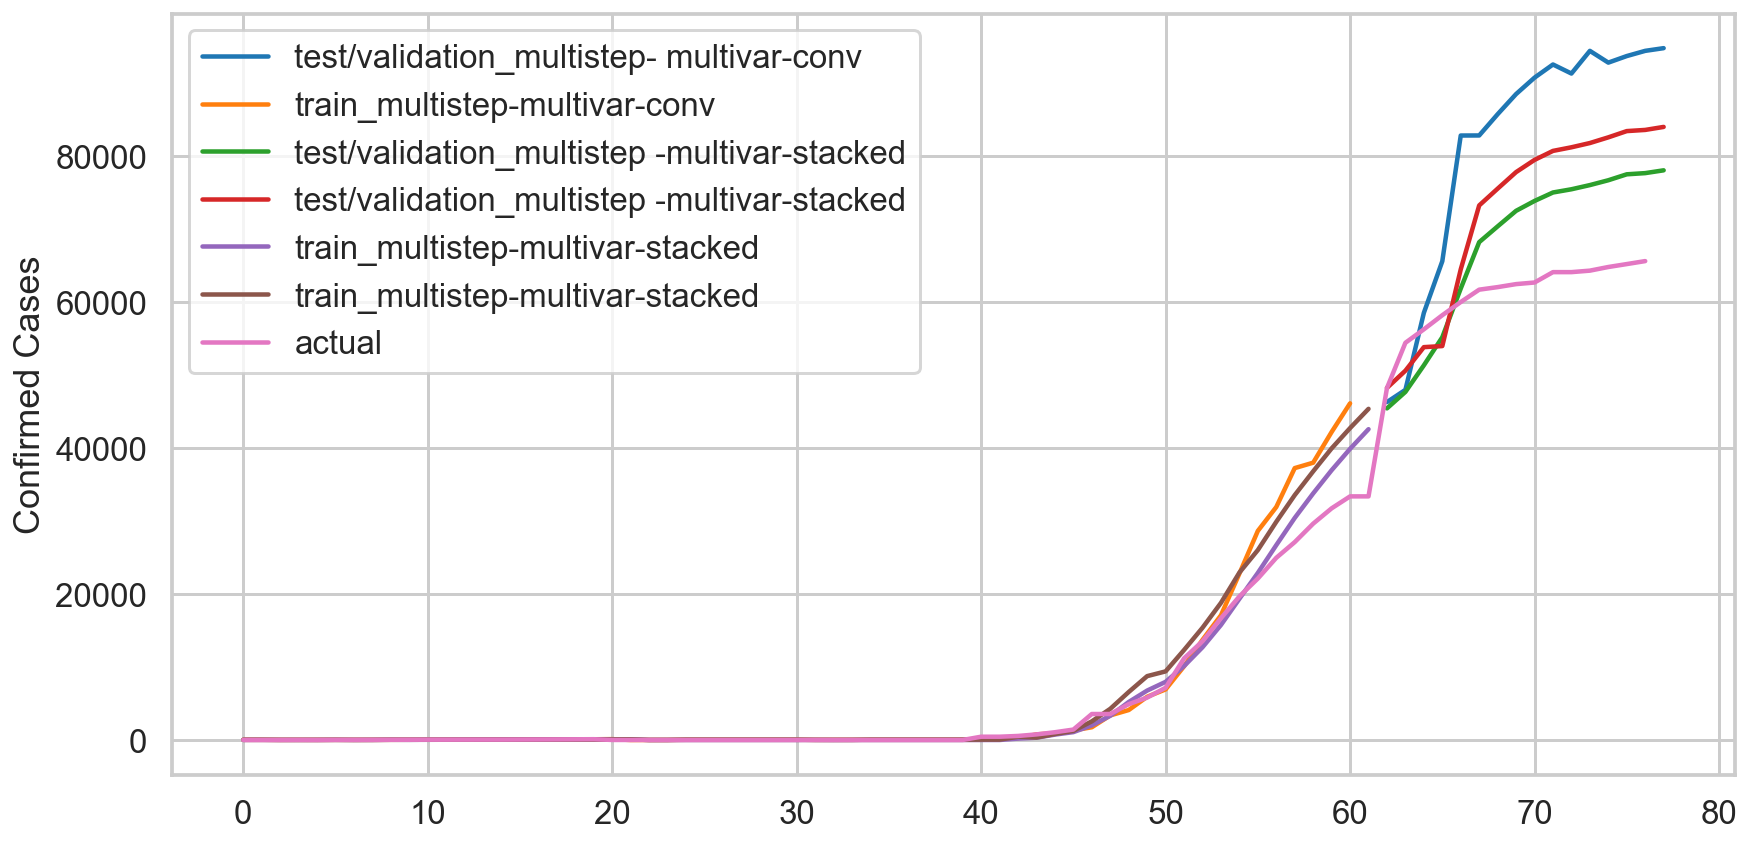

In [423]:
plt.figure(figsize=(14,7))
plt.plot(range(len(y_train_pred), len(y)+1), yhat_13, label = 'test/validation_multistep- multivar-conv')
plt.plot(y_train_pred_13, label = 'train_multistep-multivar-conv')
plt.plot(range(len(y_train_pred), len(y)+1), yhat_12, label = 'test/validation_multistep -multivar-stacked')
plt.plot(y_train_pred_12, label = 'train_multistep-multivar-stacked')
plt.plot(y, label = 'actual')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

### World

In [429]:
input_seqs = {loc:array(df.loc[df.loc_id == loc].confirmed_cases) 
              for loc in df.loc_id.unique()}
print(input_seqs[44].shape) # loc_id = 44, 82 time steps for each location

output_seq = np.empty(0)
for i in range(len(input_seqs[44])):
    output_i = 0
    for key, val in input_seqs.items():
        output_i += val[i]
    output_seq = np.append(output_seq, output_i)
print(output_seq.shape)

# convert to [rows, columns] structure
output_seq = output_seq.reshape((len(output_seq), 1))
print(output_seq.shape)

for key, val in input_seqs.items():
    input_seqs[key] = val.reshape((len(val), 1))
print(input_seqs[44].shape)

# horizontally stack columns
ar = np.empty(input_seqs[44].shape)
for i in input_seqs:
    inp = input_seqs[i]
    ar = np.append(ar, inp, axis=1)

w_ar = np.append(ar, output_seq, axis=1)

w_ar.shape

(81,)
(81,)
(81, 1)
(81, 1)


(81, 106)

In [436]:
dataset = w_ar

n_steps_in, n_steps_out = 4, 2
n_seq = 2

X, y = split_sequences_multistep(dataset, n_steps_in, n_steps_out)
X.shape

(77, 4, 105)

In [437]:
n_features = X.shape[2]
X = X.reshape(X.shape[0], n_seq, 1, n_steps, n_features)

trainX = X[:int(train_size*len(X))]
trainy = y[:int(train_size*len(y))]
testX = X[int(train_size*len(X)):]
testy = y[int(train_size*len(y)):]

# Stacked
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps_out, n_features)))
model.add(Flatten())
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_12 (ConvLSTM2D) (None, 1, 1, 64)          86784     
_________________________________________________________________
flatten_17 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 2)                 130       
Total params: 86,914
Trainable params: 86,914
Non-trainable params: 0
_________________________________________________________________


Train on 54 samples, validate on 7 samples
Epoch 1/200
54/54 [==============================] - 0s 659us/step - loss: 104832.2653 - val_loss: 227618224.0000
Epoch 2/200
54/54 [==============================] - 0s 796us/step - loss: 104461.2066 - val_loss: 225262416.0000
Epoch 3/200
54/54 [==============================] - 0s 407us/step - loss: 101849.3015 - val_loss: 222336000.0000
Epoch 4/200
54/54 [==============================] - 0s 471us/step - loss: 100250.6788 - val_loss: 217358240.0000
Epoch 5/200
54/54 [==============================] - 0s 447us/step - loss: 98821.9337 - val_loss: 213141744.0000
Epoch 6/200
54/54 [==============================] - 0s 685us/step - loss: 97547.5347 - val_loss: 208887024.0000
Epoch 7/200
54/54 [==============================] - 0s 692us/step - loss: 97066.6908 - val_loss: 204931152.0000
Epoch 8/200
54/54 [==============================] - 0s 584us/step - loss: 96379.3979 - val_loss: 201869072.0000
Epoch 9/200
54/54 [==============================

54/54 [==============================] - 0s 602us/step - loss: 70710.1036 - val_loss: 107604792.0000
Epoch 73/200
54/54 [==============================] - 0s 481us/step - loss: 70484.5692 - val_loss: 107387312.0000
Epoch 74/200
54/54 [==============================] - 0s 662us/step - loss: 70038.3465 - val_loss: 107708800.0000
Epoch 75/200
54/54 [==============================] - 0s 561us/step - loss: 69899.2433 - val_loss: 108285560.0000
Epoch 76/200
54/54 [==============================] - 0s 613us/step - loss: 72046.9225 - val_loss: 108572552.0000
Epoch 77/200
54/54 [==============================] - 0s 505us/step - loss: 69877.9945 - val_loss: 107995888.0000
Epoch 78/200
54/54 [==============================] - 0s 553us/step - loss: 69408.6065 - val_loss: 108282456.0000
Epoch 79/200
54/54 [==============================] - 0s 608us/step - loss: 68638.9971 - val_loss: 102496024.0000
Epoch 80/200
54/54 [==============================] - 0s 503us/step - loss: 67422.9141 - val_loss: 92

54/54 [==============================] - 0s 577us/step - loss: 64991.4062 - val_loss: 126331576.0000
Epoch 144/200
54/54 [==============================] - 0s 447us/step - loss: 64039.6832 - val_loss: 129842120.0000
Epoch 145/200
54/54 [==============================] - 0s 415us/step - loss: 63729.8547 - val_loss: 132693688.0000
Epoch 146/200
54/54 [==============================] - 0s 501us/step - loss: 62538.3313 - val_loss: 133252208.0000
Epoch 147/200
54/54 [==============================] - 0s 513us/step - loss: 62048.2080 - val_loss: 133466096.0000
Epoch 148/200
54/54 [==============================] - 0s 467us/step - loss: 61189.2922 - val_loss: 132827816.0000
Epoch 149/200
54/54 [==============================] - 0s 523us/step - loss: 60678.6357 - val_loss: 131913944.0000
Epoch 150/200
54/54 [==============================] - 0s 473us/step - loss: 60810.6479 - val_loss: 130816120.0000
Epoch 151/200
54/54 [==============================] - 0s 566us/step - loss: 59818.0503 - val_

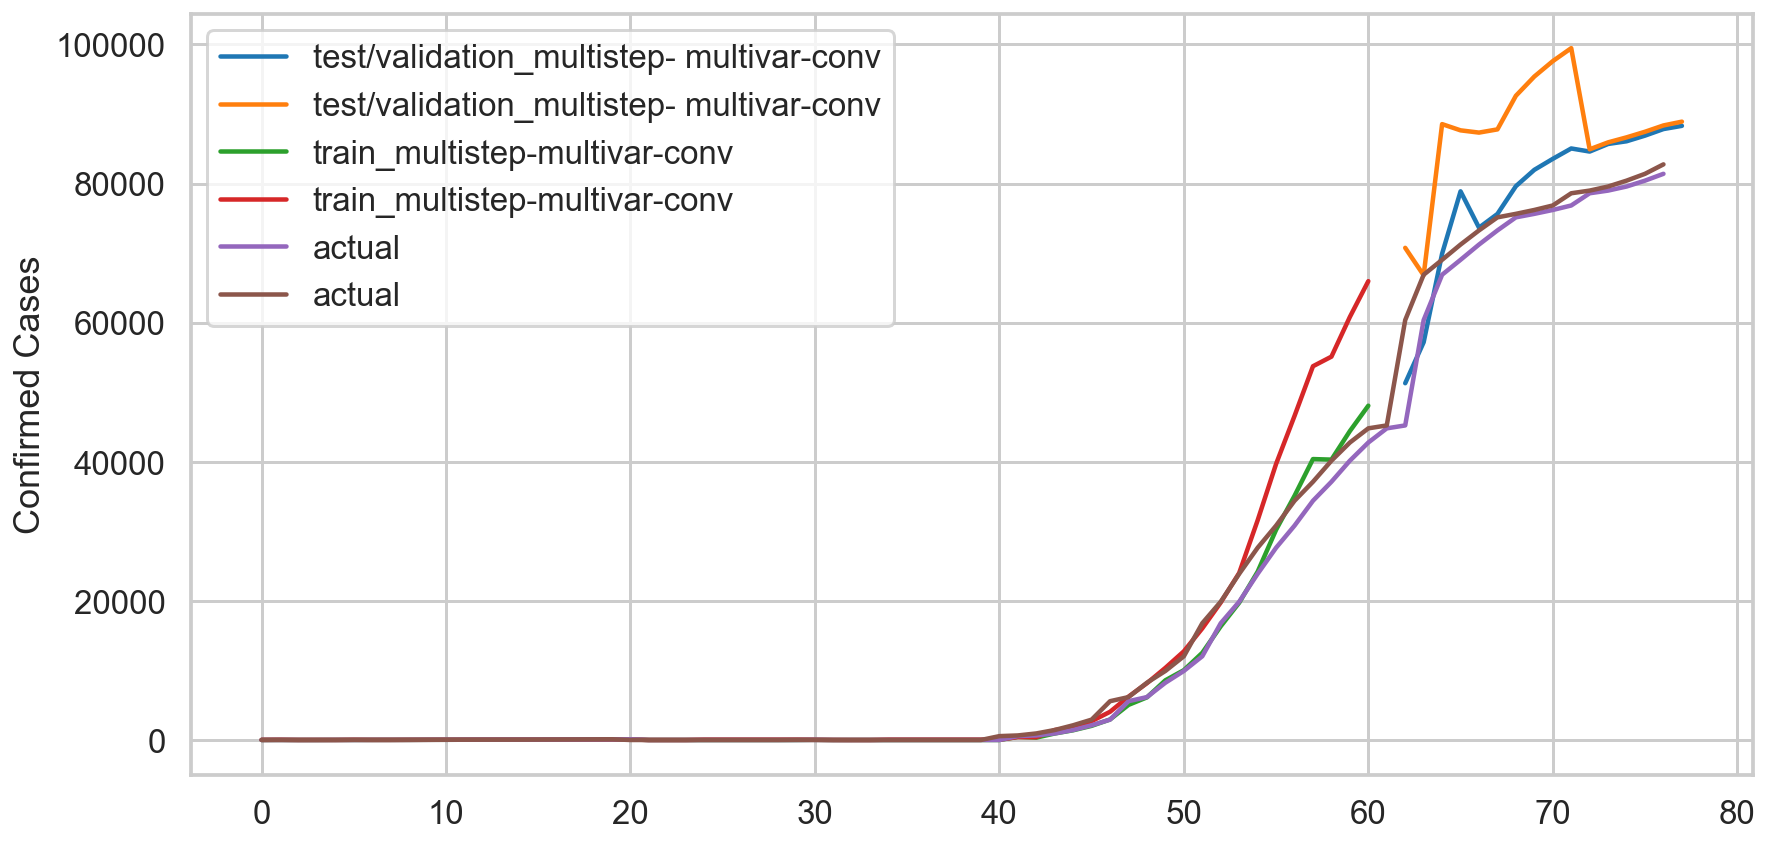

In [439]:
model.fit(trainX, trainy, epochs=200, verbose=1, validation_split = 0.1)

yhat_14 = model.predict(testX, verbose=1)
y_train_pred_14 = model.predict(trainX, verbose = 1)

plt.figure(figsize=(14,7))
plt.plot(range(len(y_train_pred), len(y)+1), yhat_14, label = 'test/validation_multistep- multivar-conv')
plt.plot(y_train_pred_14, label = 'train_multistep-multivar-conv')
plt.plot(y, label = 'actual')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.show()

# SIR Epidemic Models

Susceptible, infectious, and recovered individuals as f(t)provided transition rates between compartments.
- Nonlinear system - Monte Carlo, Gillespie algorithm
- Ro (reproduction ratio) is critical
- Idea is that the end of an epidemic is caused by the decline in the number of infected individuals rather than an absolute lack of susceptible subjects
https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model

## The basic model

Python code for curves
https://en.wikipedia.org/wiki/Gillespie_algorithm

Used in city coronavirus model here
https://lexparsimon.github.io/coronavirus/

In [32]:
import math
import random

# Input parameters ####################

# int; total population
N = 350

# float; maximum elapsed time
T = 100.0

# float; start time
t = 0.0

# float; spatial parameter
V = 100.0

# float; rate of infection after contact
_alpha = 10.0

# float; rate of cure
_beta = 0.5

# int; initial infected population
n_I = 1

#########################################

# Compute susceptible population, set recovered to zero
n_S = N - n_I
n_R = 0

# Initialize results list
SIR_data = []
SIR_data.append((t, n_S, n_I, n_R))

# Main loop
while t < T:
    if n_I == 0:
        break

    w1 = _alpha * n_S * n_I / V
    w2 = _beta * n_I
    W = w1 + w2

    dt = -math.log(random.uniform(0.0, 1.0)) / W
    t = t + dt

    if random.uniform(0.0, 1.0) < w1 / W:
        n_S = n_S - 1
        n_I = n_I + 1
    else:
        n_I = n_I - 1
        n_R = n_R + 1

    SIR_data.append((t, n_S, n_I, n_R))

with open('SIR_data.txt', 'w+') as fp:
    fp.write('\n'.join('%f %i %i %i' % x for x in SIR_data))

plt.plot(SIR_data[t], n_S)

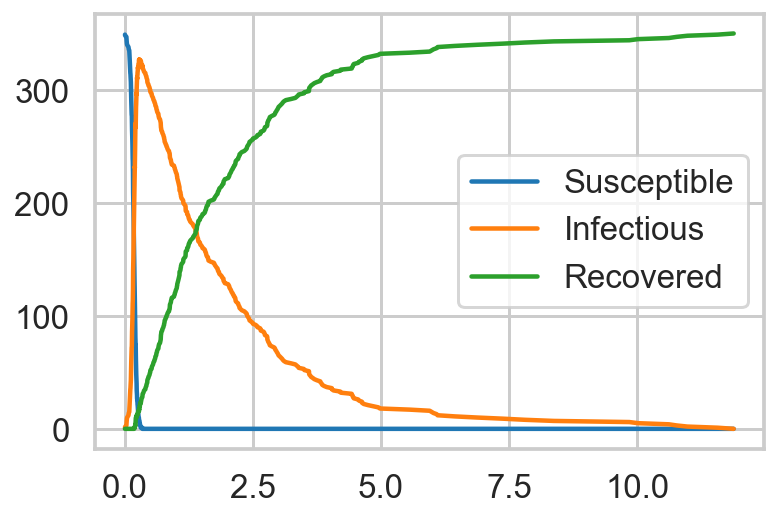

In [42]:
t = []
n_S = []
n_I = []
n_R = []

for index, val in enumerate(SIR_data):
    t.append(SIR_data[index][0])
    n_S.append(SIR_data[index][1])
    n_I.append(SIR_data[index][2])
    n_R.append(SIR_data[index][3])

plt.plot(t, n_S, label = 'Susceptible')
plt.plot(t, n_I, label = 'Infectious')
plt.plot(t, n_R, label = 'Recovered')
plt.legend()
plt.show()

In [41]:
SIR_data[1]

(0.005117699519555275, 348, 2, 0)

## SIR + origin-destination flow matrices
Modeling coronavirus based on traffic patterns in a given city -- requires an origin-destination flow matrix, which can be mathematically inferred from flux between locations within a network...https://onlinelibrary.wiley.com/doi/full/10.1002/atr.187
- Transmission rate beta randomly assigned for given location on given day
- Modal share (constant across city) or the intensity of public transport is factored in as a variable that can be adjusted to observe effects of halting transit.

Python code for running the model:
https://lexparsimon.github.io/coronavirus/

In [44]:
import numpy as np

# initialize the population vector from the origin-destination flow matrix
N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
locs_len = len(N_k)                 # number of locations
SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
SIR[:,0] = N_k                      # initialize the S group with the respective populations

first_infections = np.where(SIR[:, 0]<=thresh, SIR[:, 0]//20, 0)   # for demo purposes, randomly introduce infections
SIR[:, 0] = SIR[:, 0] - first_infections
SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group

# row normalize the SIR matrix for keeping track of group proportions
row_sums = SIR.sum(axis=1)
SIR_n = SIR / row_sums[:, np.newaxis]

# initialize parameters
beta = 1.6
gamma = 0.04
public_trans = 0.5                                 # alpha
R0 = beta/gamma
beta_vec = np.random.gamma(1.6, 2, locs_len)
gamma_vec = np.full(locs_len, gamma)
public_trans_vec = np.full(locs_len, public_trans)

# make copy of the SIR matrices 
SIR_sim = SIR.copy()
SIR_nsim = SIR_n.copy()

# run model
print(SIR_sim.sum(axis=0).sum() == N_k.sum())
from tqdm import tqdm_notebook
infected_pop_norm = []
susceptible_pop_norm = []
recovered_pop_norm = []
for time_step in tqdm_notebook(range(100)):
  infected_mat = np.array([SIR_nsim[:,1],]*locs_len).transpose()
  OD_infected = np.round(OD*infected_mat)
  inflow_infected = OD_infected.sum(axis=0)
  inflow_infected = np.round(inflow_infected*public_trans_vec)
  print('total infected inflow: ', inflow_infected.sum())
  new_infect = beta_vec*SIR_sim[:, 0]*inflow_infected/(N_k + OD.sum(axis=0))
  new_recovered = gamma_vec*SIR_sim[:, 1]
  new_infect = np.where(new_infect>SIR_sim[:, 0], SIR_sim[:, 0], new_infect)
  SIR_sim[:, 0] = SIR_sim[:, 0] - new_infect
  SIR_sim[:, 1] = SIR_sim[:, 1] + new_infect - new_recovered
  SIR_sim[:, 2] = SIR_sim[:, 2] + new_recovered
  SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
  # recompute the normalized SIR matrix
  row_sums = SIR_sim.sum(axis=1)
  SIR_nsim = SIR_sim / row_sums[:, np.newaxis]
  S = SIR_sim[:,0].sum()/N_k.sum()
  I = SIR_sim[:,1].sum()/N_k.sum()
  R = SIR_sim[:,2].sum()/N_k.sum()
  print(S, I, R, (S+I+R)*N_k.sum(), N_k.sum())
  print('\n')
  infected_pop_norm.append(I)
  susceptible_pop_norm.append(S)
  recovered_pop_norm.append(R)

NameError: name 'OD' is not defined